## Step 1: load data into python file
### Step 1.1: Load interest rate and libor rate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import os 
sns.set_style('whitegrid')

import string
from datetime import datetime
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list


def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes

def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None

def load_interest_rate():
    data_list = []
    for i in ['LIBOR_1M.csv','LIBOR_1Y.csv','LIBOR_3M.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.columns = [i[:-4]]
        data_list.append(df)
    libor_rate = pd.concat(data_list,axis=1).dropna()
    for i in range(3):
        libor_rate.iloc[:,i] = libor_rate.iloc[:,i].astype(float).round(4)
        
    data_list = []
    for i in ['interbank_sonia.csv','interbank_1M.csv','interbank_1Y.csv','Euro_currency_offered_rates_USD.csv','Euro_currency_offered_rates_EUR.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
        df.columns = [i[:-4]]
        data_list.append(df)
    sonia_rate = data_list[0].join(data_list[1]).join(data_list[2]).join(data_list[3]).join(data_list[4])
    merged_dataset = libor_rate.join(sonia_rate,how='outer')
    items = list(merged_dataset)
    merged_dataset = merged_dataset.loc[merged_dataset.index>'1997-01-01',:]
    return merged_dataset

def create_label_for_dictionary(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]
    threshold = 0.1
    for i in range(12,len(rate_change)-12):
        if list_of_value[i]-list_of_value[i+12]>threshold:
            rate_change[i] = -1
            plot_negative[i] = list_of_value[i]
        elif list_of_value[i]-list_of_value[i+12]<-threshold:
            rate_change[i] = 1
            plot_positive[i] = list_of_value[i]
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change

def create_label_for_dictionary_2(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]

    N = len(rate_change)
    for i in range(0,N-8):
        for k in range(7):
            if list_of_value[i+k] == list_of_value[i+k+1]:
                pass
            elif list_of_value[i+k] > list_of_value[i+k+1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]
                break
            elif list_of_value[i+k] < list_of_value[i+k+1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i]
                break
        if rate_change[i] == 0 and i>=1:
            if list_of_value[i] > list_of_value[i-1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i] 
            elif list_of_value[i] < list_of_value[i-1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]                
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


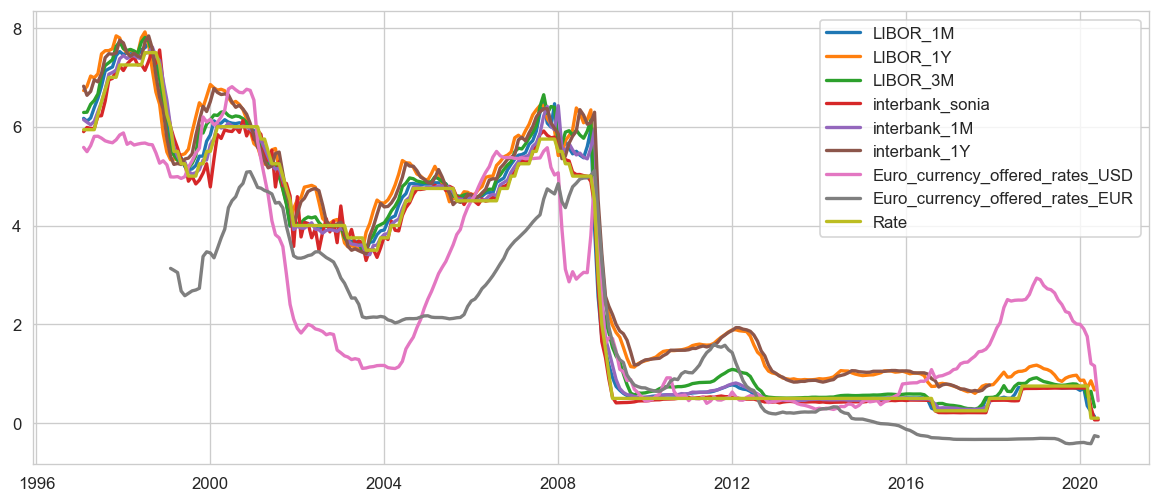

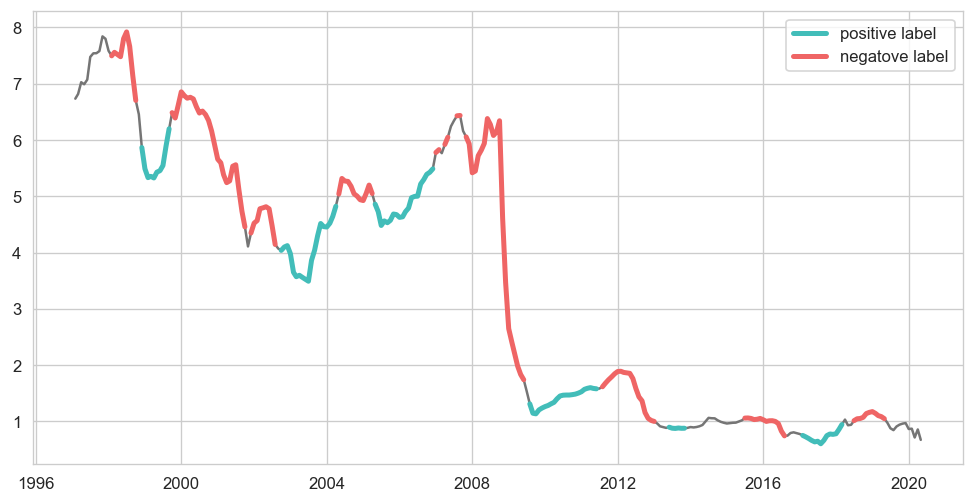

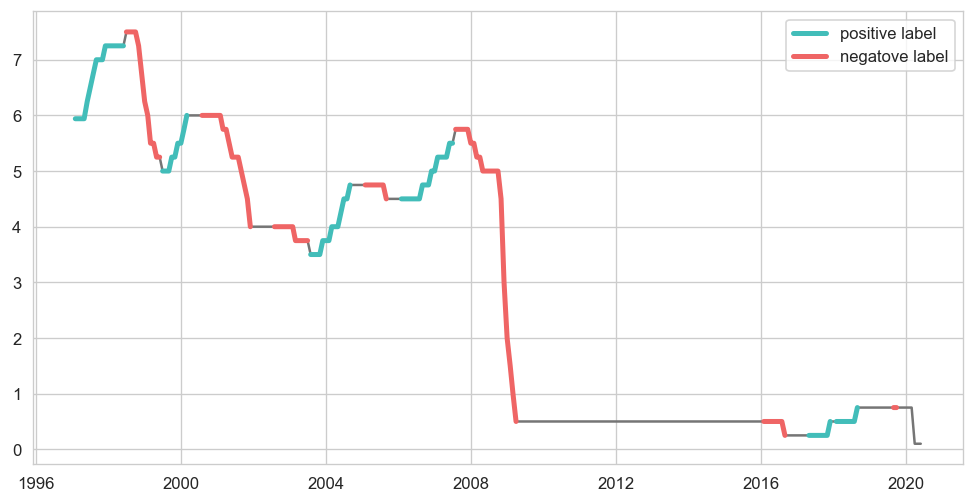

In [4]:
merged_dataset = load_interest_rate()

base_rate = pd.read_csv('./scripter/cleaned_dataset/Bank Rate  Bank of England Database.csv',index_col = 0)
base_rate.index = pd.DatetimeIndex(base_rate.index)
base_rate = base_rate.reindex(pd.date_range(start = base_rate.index[-1], end = merged_dataset.index[-1]))
for i in range(1,len(base_rate)):
    if base_rate.iloc[i,0]!=base_rate.iloc[i,0]:
        base_rate.iloc[i,0]=base_rate.iloc[i-1,0]
merged_dataset = merged_dataset.join(base_rate,how='inner')
items = list(merged_dataset)
plt.figure(figsize=(12,5),dpi=120)
for i in range(len(items)):
    plt.plot(merged_dataset.index,merged_dataset.iloc[:,i].values,label = items[i],lw=2)
plt.legend()
plt.show()

date_range = merged_dataset.index
list_of_value = merged_dataset.LIBOR_1Y.values
rate_change = create_label_for_dictionary(list_of_value,date_range)
date_range = merged_dataset.index
list_of_value_2 = merged_dataset.Rate.values
rate_change_2 = create_label_for_dictionary_2(list_of_value_2,date_range)

### Step 1.2: load speech data

In [5]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora

def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech

def sentiment_calculator_speech(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += para+' '
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def filter_speech_language(string,topics,thre=0.65):
    result = {i:[] for i in topics}
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    doc_list_cleaned = preprocess_data(doc_list)
    _, corpus =  prepare_corpus(doc_list_cleaned)
    corpus_tfidf = TfidfModel(corpus)[corpus]
    k=0
    for n,sentence in enumerate(corpus_tfidf):
        a = model_2.get_document_topics(sentence)
        a.sort(key=lambda x:-x[1])
        topic = topics[a[0][0]]
        if a[0][1]>= thre:
            result[topic].append(doc_list[n])
            k+=1
    result = [[topic]+result[topic] for topic in topics]  
    print('\r{} of all sentences in speech were kept'.format(np.round(k/(len(corpus_tfidf)+1),3)),end='')
    return result

model_2 =  LdaMulticore.load('.\Dictionary_based_method\lda_minutes.model')

In [6]:
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']
MPC_speech = load_up_from_cleaned_speech()
# now apply the above method and covnert the language of speech
MPC_speech.loc[:,'N_topics'] = MPC_speech.loc[:,'document_string'].apply(lambda x: filter_speech_language(x,topics[:-1],thre=0.65))
speech_timeseries = MPC_speech.set_index('date')
speech_timeseries.index = pd.DatetimeIndex(speech_timeseries.index)+pd.offsets.MonthBegin(0)
speech_timeseries = speech_timeseries.loc[:,['title','N_topics']]
speech_timeseries.loc[:,'Type'] = 'Speech'
speech_timeseries.head()


0.397 of all sentences in speech were kept

title  \
date                                                            
2020-06-01  Covid-19 and monetary policy - speech by Micha...   
2020-05-01  Monetary policy and the Bank of England’s bala...   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-04-01  The grand unifying theory (and practice) of ma...   
2020-04-01  Inflation and beliefs about inflation - speech...   

                                                     N_topics    Type  
date                                                                   
2020-06-01  [[Financial markets, Moreover, with limited mo...  Speech  
2020-05-01  [[Financial markets, It is far more complex th...  Speech  
2020-05-01  [[Financial markets, Second, the policy respon...  Speech  
2020-04-01  [[Financial markets, Macroprudential policy is...  Speech  
2020-04-01  [[Financial markets, Precisely for that reason...  Speech

### Step 1.3: load minutes data

In [7]:
MPC_minutes = pd.read_hdf('data.h5', 'minutes')
minutes_timeseries2 = MPC_minutes.loc[:,['date','title','N_topics']]
minutes_timeseries2 = minutes_timeseries2.set_index('date')
minutes_timeseries2.index = pd.DatetimeIndex(minutes_timeseries2.index)+pd.offsets.MonthBegin(0)
minutes_timeseries2.loc[:,'Type'] = 'Minutes'
minutes_timeseries2.head()

title  \
date                                                            
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-04-01       Bank Rate maintained at 01% - March 2020_1st   
2020-04-01  Minutes of the special Monetary Policy Committ...   
2020-02-01    Bank Rate maintained at 075% - January 2020_1st   
2020-01-01   Bank Rate maintained at 075% - December 2019_1st   

                                                     N_topics     Type  
date                                                                    
2020-06-01  [[Growth and inflation projections, Authoritie...  Minutes  
2020-04-01  [[Growth and inflation projections, The Bank o...  Minutes  
2020-04-01  [[Financial markets, Since the January MPC mee...  Minutes  
2020-02-01  [[Growth and inflation projections, The Bank o...  Minutes  
2020-01-01  [[Growth and inflation projections, The Bank o...  Minutes

### Step 1.4: created a merged dataset including both minutes and speech

In [259]:
merged_timeseries_labelled = pd.concat([speech_timeseries,minutes_timeseries2]).sort_index(ascending=False)
merged_timeseries_labelled.to_hdf('data.h5', key='merged_all', mode='r+')
label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_labelled.index]
merged_timeseries_labelled.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_labelled.index]
merged_timeseries_labelled.loc[:,'label_2'] = label_list
merged_timeseries_labelled.head()

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['title', 'N_topics', 'Type'], dtype='object')]

  encoding=encoding,


title  \
date                                                            
2020-06-01  Covid-19 and monetary policy - speech by Micha...   
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-05-01  Monetary policy and the Bank of England’s bala...   
2020-04-01  Minutes of the special Monetary Policy Committ...   

                                                     N_topics     Type  label  \
date                                                                            
2020-06-01  [[Financial markets, Moreover, with limited mo...   Speech      0   
2020-06-01  [[Growth and inflation projections, Authoritie...  Minutes      0   
2020-05-01  [[Financial markets, Second, the policy respon...   Speech      0   
2020-05-01  [[Financial markets, It is far more complex th...   Speech      0   
2020-04-01  [[Financial markets, Since the January MPC mee...  Minutes      0   

            label_2  
date                 
2020-06-01        0  
2020-06-01        0  
2020-05-01        0  
2020-05-01        0  
2020-04-01        0

In [9]:
speech_timeseries_labelled  = merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Speech',:]
minutes_timeseries_labelled = merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Minutes',:]

## Step 2: construction of probability based sentiment
### Step 2.1: training the model using merged dataset

In [26]:
my_color = ['#ef6565','#42bdb9','#ffd000']

def create_word_frequency(positve_rate_change):

    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}

    for doc in positve_rate_change.N_topics:
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            all_corpus['All'].append(preprocess_data(para[1:]))

    for i in topics:
        for corpus in all_corpus[i]:
            for sentence in corpus:
                for token in sentence:
                    if token not in wordfreq[i].keys():
                        wordfreq[i][token] = 1
                    else:
                        wordfreq[i][token] += 1
        wordfreq[i] = {k: v for k, v in sorted(wordfreq[i].items(), key=lambda item: -item[1])} # sorting
    return wordfreq

def create_doc_frequency(positve_rate_change):
    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}
    
    for doc in positve_rate_change.N_topics:
        document = []
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            document += para[1:]
        all_corpus['All'].append(preprocess_data(document))

    for i in topics:
        for corpus in all_corpus[i]:
            seen_word = []
            for sentence in corpus:
                for token in sentence:
                    if token not in seen_word:
                        seen_word.append(token)
                        if token not in wordfreq[i].keys():
                            wordfreq[i][token] = 1
                        else:
                            wordfreq[i][token] += 1
    return wordfreq

def load_LM_dictionary():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict

def load_FS_dictionary():
    FS_dict = pd.read_excel('./Dictionary_based_method/Stability_dictionary.xlsx')
    FS_dict.loc[FS_dict.loc[:,'Positive']==1,'sentiment'] = 'Positive'
    FS_dict.loc[FS_dict.loc[:,'Negative']==1,'sentiment'] = 'Negative'
    FS_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in FS_dict.loc[:,'Word'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]    
    FS_dict = FS_dict.loc[:,['Entry','sentiment']]
    FS_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True)
    return FS_dict



def find_frequency(word,dictionary,topic):
    if word in dictionary[topic].keys():
        return dictionary[topic][word]
    else:
        return 0


# def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
#     sentiment = []
#     word_list_all = word_list[topic]
#     word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
#     positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False).index
#     positive = list(positive)[:min(200,len(positive))]
#     sentiment += ['Positive' for i in enumerate(positive)]
#     negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False).index
#     negative = list(negative)[:min(200,len(negative))]
#     sentiment += ['Negative' for i in enumerate(negative)]
#     Entry = positive+negative
#     New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
#     return New_dictionary


def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
    sentiment = []
    FS_dict = load_FS_dictionary().set_index('Entry')
    word_list_all = word_list[topic]
    FS_dict = FS_dict.join(word_list_all,how='inner')

    word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
    positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False)
    
    negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False)
    positive = positive.iloc[:min(100,len(positive)),:]
    negative = negative.iloc[:min(100,len(negative)),:]

    selected = pd.concat([positive,negative])

    Positive = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Positive',:].loc[FS_dict.loc[:,'p percentage no neutral']>0.5,:]
    positive = list(positive.index)+list(Positive.index)
    sentiment += ['Positive' for i in enumerate(positive)]


    Negative = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Negative',:].loc[FS_dict.loc[:,'n percentage no neutral']>0.5,:]
    negative = list(negative.index)+list(Negative.index)
    sentiment += ['Negative' for i in enumerate(negative)]

    Entry = positive+negative
    New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})


    a = pd.concat([Positive.iloc[:,1:],Negative.iloc[:,1:],selected]).drop_duplicates()
    FS_dict = load_FS_dictionary().set_index('Entry')
    FS_dict.columns = ['FS_sentiment']
    FS_dict = FS_dict.join(a,how='outer')

    FS_dict.loc[:,'Model_sentiment']=np.nan
    for word in positive:
        FS_dict.loc[word,'Model_sentiment'] = 'Positive'
    for word in negative:
        FS_dict.loc[word,'Model_sentiment'] = 'Negative'
    
    return New_dictionary,FS_dict





def create_cooccurence_list(minutes_timeseries,label='label'):
    positve_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==1,:]
    negative_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==-1,:]
    neutral_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==0,:]
    print('Positive count:{}   Negative count:{}   Neutral count:{}'.format(len(positve_rate_change),len(negative_rate_change),len(neutral_rate_change)))
    print('calculate word frequency')
    postive_doc_freq = create_doc_frequency(positve_rate_change)
    negative_doc_freq = create_doc_frequency(negative_rate_change)
    neutral_doc_freq = create_doc_frequency(neutral_rate_change)

    multiplier = len(positve_rate_change)/len(negative_rate_change)
    multiplier_ne = len(neutral_rate_change)/len(negative_rate_change)
    result = {}
    for topic in topics:
        print('create dictionary for topic: '+topic)
        doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
            }).join(
                pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
                how ='outer'
            ).join(
                pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
                how ='outer'
            ).fillna(0)
        doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
        doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

        doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
        result[topic] = doc_count_df
    return result

   
def training_dictionary_sentiment(minutes_timeseries,para_set=[[20,0.55,0.6],[10,0.55,0.6]],doc_name='untitled'):
    # approximate 3 mins
    writer = pd.ExcelWriter('./Dictionary_based_method/Dictionary_data/{}.xlsx'.format(doc_name), engine='xlsxwriter')

    # Close the Pandas Excel writer and output the Excel file.    
    word_list_libor    = create_cooccurence_list(minutes_timeseries,'label')
    word_list_baserate = create_cooccurence_list(minutes_timeseries,'label_2')
    
    custome_base_all,FS_dict  = create_custom_dictionary(word_list_baserate,'All',para=para_set[0])
    FS_dict.to_excel(writer, sheet_name='custome_base_all')
    custome_libor_all,FS_dict = create_custom_dictionary(word_list_libor,'All',para=para_set[0])
    FS_dict.to_excel(writer, sheet_name='custome_libor_all')
    
    custome_base_topic  = {}
    custome_libor_topic = {}
    for n,topic in enumerate(topics):
        if topic !='All':
            custome_base_topic[topic],FS_dict  = create_custom_dictionary(word_list_baserate,topic,para=para_set[1])
            FS_dict.to_excel(writer, sheet_name='base_topic_{}'.format(n+1), startrow = 1)
            worksheet = writer.sheets['base_topic_{}'.format(n+1)]
            worksheet.write_string(0, 0, topic)

            custome_libor_topic[topic],FS_dict = create_custom_dictionary(word_list_libor,topic,para=para_set[1])
            FS_dict.to_excel(writer, sheet_name='libor_topic_{}'.format(n+1), startrow = 1)
            worksheet = writer.sheets['libor_topic_{}'.format(n+1)]
            worksheet.write_string(0, 0, topic)
    writer.save()
    return (word_list_libor,word_list_baserate),(custome_base_all,custome_libor_all,custome_base_topic,custome_libor_topic)



def remove_duplicates(dictionary_model_97_11):
    a = dictionary_model_97_11[0].drop_duplicates()
    b = dictionary_model_97_11[1].drop_duplicates()
    c,d={},{}
    for topic in dictionary_model_97_11[2].keys():
        c[topic] = dictionary_model_97_11[2][topic].drop_duplicates()
        d[topic] = dictionary_model_97_11[3][topic].drop_duplicates()
    return (a,b,c,d)

def create_probability_model(word_document_frequency_97_11,dictionary_model_97_11):
    libor_word = word_document_frequency_97_11[0]
    base_word =  word_document_frequency_97_11[1]
    a = dictionary_model_97_11[0].set_index('Entry').join(base_word['All'].loc[:,'p percentage no neutral'])
    b = dictionary_model_97_11[1].set_index('Entry').join(libor_word['All'].loc[:,'p percentage no neutral'])
    c={}
    d={}
    for topic in dictionary_model_97_11[2].keys():
        c[topic] = dictionary_model_97_11[2][topic].set_index('Entry').join(base_word[topic].loc[:,'p percentage no neutral'])
        d[topic] = dictionary_model_97_11[3][topic].set_index('Entry').join(libor_word[topic].loc[:,'p percentage no neutral'])
    return (a,b,c,d)

def create_comparison_plot(df1,column,rate = 'Interest_rate',end_date=''):
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,df1.loc[:,column].values,color = my_color[0],label = column)
    ax1.plot(df1.index,df1.label_2.values,color = my_color[1],label = 'Targeted sentiment index')
    if end_date!='':
        ax1.axvline(pd.to_datetime(end_date), -1, 1, color='#387a6f',alpha=0.5,lw=7, label='training data end')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='lower right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.title('plot against to '+rate)
    plt.show()
    return None   

def sentiment_calculator_topic_prob(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Positive_df.loc[x,'p percentage no neutral'] for x in Positive_df.index]
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Negative_df.loc[x,'p percentage no neutral'] for x in Negative_df.index]

        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan

    
def sentiment_calculator_prob(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Positive_df.loc[x,'p percentage no neutral'] for x in Positive_df.index]
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = [stemmed_tokens.count(x)*Negative_df.loc[x,'p percentage no neutral'] for x in Negative_df.index]

    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan    

def result_dictionary_sentiment_prob(dictionary_model_2020,interested_topics,testing_data=pd.read_hdf('data.h5', 'minutes')):
    print('calculating all')
    dictionary_sentiment = testing_data.copy()
    dictionary_sentiment.loc[:,'base_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_prob(dictionary_model_2020[0],x))
    #dictionary_sentiment.loc[:,'libor_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_prob(dictionary_model_2020[1],x))
    for topic in interested_topics:
        print('calculating topic: {}'.format(topic))
        dictionary_sentiment.loc[:,'base_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic_prob(dictionary_model_2020[2][topic],x,topic))
        #dictionary_sentiment.loc[:,'libor_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic_prob(dictionary_model_2020[3][topic],x,topic))
    dictionary_sentiment.loc[:,'Topical_mean_base'] = dictionary_sentiment.loc[:,['base_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    #dictionary_sentiment.loc[:,'Topical_mean_libor'] = dictionary_sentiment.loc[:,['libor_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    FS_dict = load_FS_dictionary()
    LM_dict = load_LM_dictionary()
    print('calculating dictionary sentiment')
    dictionary_sentiment.loc[:,'FS_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(FS_dict,x))
    dictionary_sentiment.loc[:,'LM_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(LM_dict,x))
    return dictionary_sentiment

def rolling_averaging_ewm(df,start = '1997-02-25', end ='2020-01-28',addition=[]):
    df1 = df.groupby(df.index).mean()
    merged_dataset.loc[:,'LIBOR_1Y_change'] = [np.nan]+list((merged_dataset.LIBOR_1Y.values[1:] - merged_dataset.LIBOR_1Y.values[:-1])/merged_dataset.LIBOR_1Y.values[:-1])
    df1 = df1.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner')
    df2 = df1.loc[:,['LIBOR_1Y_change','base_all_sentiment']+addition]
    df2 = (df2-df2.mean())/df2.std()
    df1 = df1.reindex(pd.date_range(start, end))
    df1 = df1.ewm(halflife=60).mean()
    df1.index = df1.index+pd.offsets.MonthBegin(0)
    df1 = df1.groupby(df1.index).mean()
    df1 =  df1.join(pd.DataFrame(data={'Interest_rate':list_of_value_2},index = date_range),how = 'inner')
    y = list_of_value_2[1:] - list_of_value_2[:-1]
    df1 =  df1.join(pd.DataFrame(data={'change_of_rate':y},index = date_range[:-1]),how = 'inner')
    
    return df1,df2   
    
def visualise_prob_model(sentiment_97_15_merged_prob):
    sentiment_97_15_merged_prob.loc[:,'base_all_sentiment_2'] = (sentiment_97_15_merged_prob.loc[:,'base_all_sentiment']-sentiment_97_15_merged_prob.loc[:,'base_all_sentiment'].mean())/np.std(sentiment_97_15_merged_prob.loc[:,'base_all_sentiment'])
    create_comparison_plot(sentiment_97_15_merged_prob,'base_all_sentiment_2',rate = 'change_of_rate', end_date=end_date)
    create_comparison_plot(sentiment_97_15_merged_prob,'base_all_sentiment_2',rate = 'LIBOR_1Y_change', end_date=end_date)
    sentiment_97_15_merged_prob.loc[:,'Topical_mean_base_2'] = (sentiment_97_15_merged_prob.loc[:,'Topical_mean_base']-sentiment_97_15_merged_prob.loc[:,'Topical_mean_base'].mean())/np.std(sentiment_97_15_merged_prob.loc[:,'Topical_mean_base'])
    create_comparison_plot(sentiment_97_15_merged_prob,'Topical_mean_base_2',rate = 'change_of_rate', end_date=end_date)
    return None
def sentiment_calculator_topic(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan

    
def sentiment_calculator(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan

def create_dictionary_visualisation(word_document_frequency_97_05,para):
    for topic in ['All']+interested_topics:
        word_list_all = word_document_frequency_97_05[1][topic]
        word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
        positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'])
        negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'])
        d = {}
        for word in positive.index:
            d[word] = positive.loc[word,'p percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Positive',fontsize=14)
        plt.axis("off")

        d = {}
        for word in negative.index:
            d[word] = negative.loc[word,'n percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Negative',fontsize=14)
        plt.axis("off")
        plt.suptitle('word cloud for topic: '+topic,fontsize=20)
        plt.show()
    return None

In [12]:
end_date, start_date='2015-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']


training_data = merged_timeseries_labelled.loc[end_date:start_date,:]
word_document_frequency_97_15_merged,dictionary_model_97_15_merged = training_dictionary_sentiment(training_data,para_set=[[50,0.55,0.55],[30,0.55,0.55]],doc_name='9715_speech_minutes_second')
dictionary_model_97_15_merged = remove_duplicates(dictionary_model_97_15_merged)
model = create_probability_model(word_document_frequency_97_15_merged,dictionary_model_97_15_merged)

Positive count:287   Negative count:396   Neutral count:145
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:154   Negative count:244   Neutral count:430
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All


In [20]:
end_date2, start_date2='2009-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']


training_data2 = merged_timeseries_labelled.loc[end_date2:start_date2,:]
word_document_frequency_97_10_merged,dictionary_model_97_10_merged = training_dictionary_sentiment(training_data2,para_set=[[50,0.55,0.55],[30,0.55,0.55]],doc_name='9710_speech_minutes_second')
dictionary_model_97_10_merged = remove_duplicates(dictionary_model_97_10_merged)
model2 = create_probability_model(word_document_frequency_97_10_merged,dictionary_model_97_10_merged)

Positive count:179   Negative count:284   Neutral count:34
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:154   Negative count:244   Neutral count:99
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All


### Step 2.2: implement training model

#### trained on 1997-2015

calculating all
calculating topic: Financial markets
calculating topic: The immediate policy decision
calculating topic: Growth and inflation projections
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy
calculating dictionary sentiment


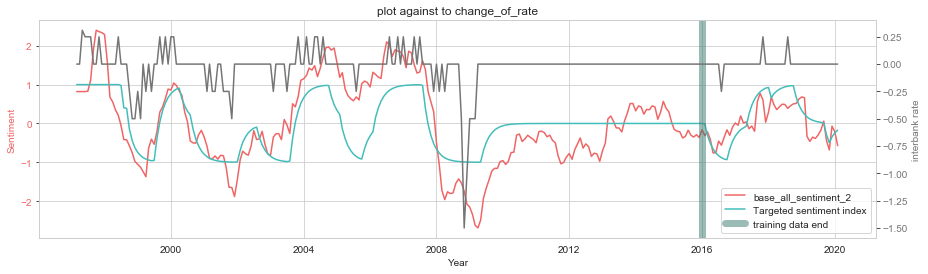

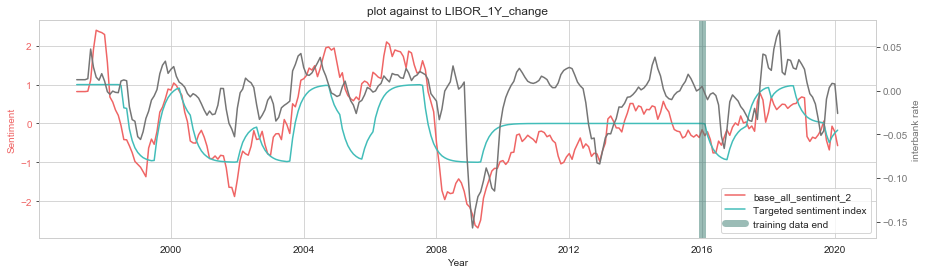

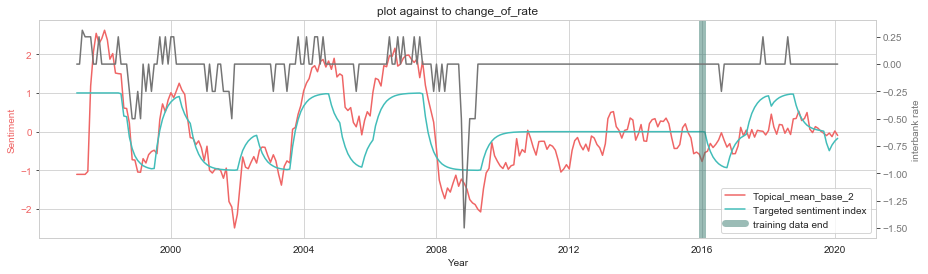

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.735861             0.734542      0.418345
LIBOR_1Y_change              0.566290             0.448057      0.356398
Interest_rate                0.299555             0.316234      0.193452
change_of_rate               0.448649             0.373829      0.382813
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change             1.00000             0.31233
base_all_sentiment          0.31233             1.00000


label   label_2  \
label                                            1.000000  0.285358   
label_2                                          0.285358  1.000000   
base_all_sentiment                               0.383083  0.735861   
base_Financial markets_sentiment                 0.315505  0.778451   
base_The immediate policy decision_sentiment     0.154577  0.677229   
base_Growth and inflation projections_sentiment  0.260074  0.667853   
base_Money, credit, demand and output_sentiment  0.205258  0.538760   
base_Supply, costs and prices_sentiment          0.073268  0.327098   
base_The international economy_sentiment         0.314448  0.468217   
Topical_mean_base                                0.239787  0.734542   
FS_sentiment                                     0.193030  0.418345   
LM_sentiment                                    -0.048589 -0.104235   
LIBOR_1Y_change                                  0.327774  0.527780   
Interest_rate                                   -0.142672  0.084169   
change_of_rate                                   0.242925  0.482741   
base_all_sentiment_2                             0.383083  0.735861   
Topical_mean_base_2                              0.239787  0.734542   

                                                 base_all_sentiment  \
label                                                      0.383083   
label_2                                                    0.735861   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.850985   
base_The immediate policy decision_sentiment               0.765217   
base_Growth and inflation projections_sentiment            0.802006   
base_Money, credit, demand and output_sentiment            0.651264   
base_Supply, costs and prices_sentiment                    0.502707   
base_The international economy_sentiment                   0.588610   
Topical_mean_base                                          0.888010   
FS_sentiment                                               0.611570   
LM_sentiment                                               0.108305   
LIBOR_1Y_change                                            0.566290   
Interest_rate                                              0.299555   
change_of_rate                                             0.448649   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.888010   

                                                 base_Financial markets_sentiment  \
label                                                                    0.315505   
label_2                                                                  0.778451   
base_all_sentiment                                                       0.850985   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.647833   
base_Growth and inflation projections_sentiment                          0.716845   
base_Money, credit, demand and output_sentiment                          0.541183   
base_Supply, costs and prices_sentiment                                  0.482478   
base_The international economy_sentiment                                 0.486886   
Topical_mean_base                                                        0.842836   
FS_sentiment                                                             0.525960   
LM_sentiment                                                            -0.055908   
LIBOR_1Y_change                                                          0.485042   
Interest_rate                                                            0.218656   
change_of_rate                                                           0.441617   
base_all_sentiment_2                                                     0.850985   
Topical_mean_base_2                              

In [13]:
end_date, start_date='2015-12-31','1997-08-01'
sentiment_97_15_merged_prob = result_dictionary_sentiment_prob(model,interested_topics,merged_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_15_merged_prob)
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

calculating all
calculating topic: Financial markets
calculating topic: The immediate policy decision
calculating topic: Growth and inflation projections
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy
calculating dictionary sentiment


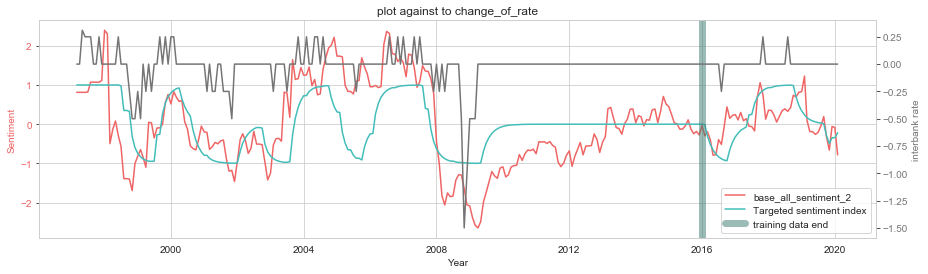

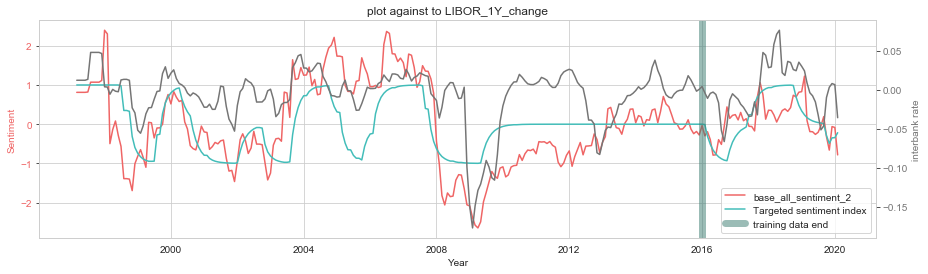

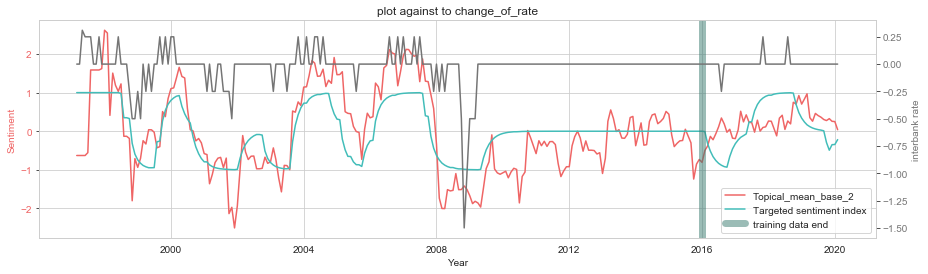

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.603019             0.709848      0.270305
LIBOR_1Y_change              0.513539             0.470417      0.289794
Interest_rate                0.253288             0.264407      0.259313
change_of_rate               0.399895             0.384217      0.229047
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.261025
base_all_sentiment         0.261025            1.000000


label   label_2  \
label                                            1.000000  0.269373   
label_2                                          0.269373  1.000000   
base_all_sentiment                               0.328190  0.603019   
base_Financial markets_sentiment                 0.217856  0.693837   
base_The immediate policy decision_sentiment     0.141293  0.629590   
base_Growth and inflation projections_sentiment  0.267763  0.635609   
base_Money, credit, demand and output_sentiment  0.046364  0.164519   
base_Supply, costs and prices_sentiment          0.036588  0.111026   
base_The international economy_sentiment         0.106817  0.090915   
Topical_mean_base                                0.206193  0.709848   
FS_sentiment                                     0.048927  0.270305   
LM_sentiment                                    -0.037282 -0.008170   
LIBOR_1Y_change                                  0.316833  0.559239   
Interest_rate                                   -0.149971  0.098248   
change_of_rate                                   0.229871  0.474128   
base_all_sentiment_2                             0.328190  0.603019   
Topical_mean_base_2                              0.206193  0.709848   

                                                 base_all_sentiment  \
label                                                      0.328190   
label_2                                                    0.603019   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.759815   
base_The immediate policy decision_sentiment               0.588615   
base_Growth and inflation projections_sentiment            0.767035   
base_Money, credit, demand and output_sentiment            0.179465   
base_Supply, costs and prices_sentiment                    0.341159   
base_The international economy_sentiment                   0.286458   
Topical_mean_base                                          0.824561   
FS_sentiment                                               0.549166   
LM_sentiment                                               0.123715   
LIBOR_1Y_change                                            0.513539   
Interest_rate                                              0.253288   
change_of_rate                                             0.399895   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.824561   

                                                 base_Financial markets_sentiment  \
label                                                                    0.217856   
label_2                                                                  0.693837   
base_all_sentiment                                                       0.759815   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.437571   
base_Growth and inflation projections_sentiment                          0.639961   
base_Money, credit, demand and output_sentiment                          0.146095   
base_Supply, costs and prices_sentiment                                  0.310513   
base_The international economy_sentiment                                 0.179370   
Topical_mean_base                                                        0.798251   
FS_sentiment                                                             0.542725   
LM_sentiment                                                             0.129179   
LIBOR_1Y_change                                                          0.469622   
Interest_rate                                                            0.283137   
change_of_rate                                                           0.432913   
base_all_sentiment_2                                                     0.759815   
Topical_mean_base_2                              

In [14]:
end_date, start_date='2015-12-31','1997-08-01'
sentiment_97_15_speech_prob = result_dictionary_sentiment_prob(model,interested_topics,speech_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_15_speech_prob)
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

calculating all
calculating topic: Financial markets
calculating topic: The immediate policy decision
calculating topic: Growth and inflation projections
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy
calculating dictionary sentiment


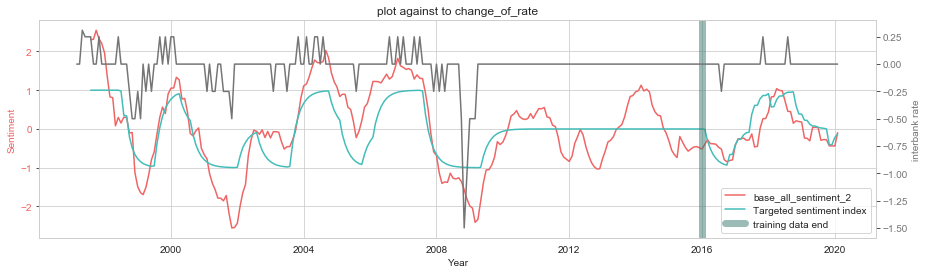

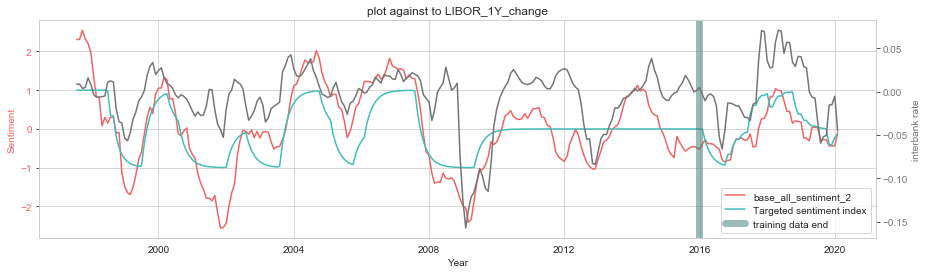

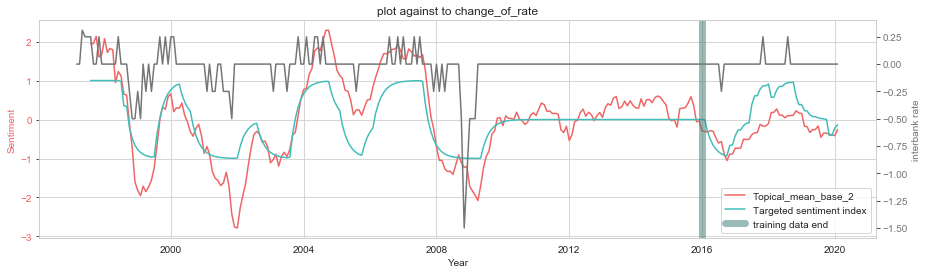

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.792457             0.818380      0.469539
LIBOR_1Y_change              0.561908             0.444900      0.353912
Interest_rate                0.194781             0.155573      0.245016
change_of_rate               0.465796             0.435961      0.408340
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.385039
base_all_sentiment         0.385039            1.000000


label   label_2  \
label                                            1.000000  0.280419   
label_2                                          0.280419  1.000000   
base_all_sentiment                               0.447433  0.792457   
base_Financial markets_sentiment                 0.390348  0.737424   
base_The immediate policy decision_sentiment     0.201417  0.781809   
base_Growth and inflation projections_sentiment  0.227231  0.612613   
base_Money, credit, demand and output_sentiment  0.230170  0.688563   
base_Supply, costs and prices_sentiment          0.213551  0.755445   
base_The international economy_sentiment         0.343669  0.734959   
Topical_mean_base                                0.293289  0.818380   
FS_sentiment                                     0.399016  0.469539   
LM_sentiment                                     0.066243 -0.074664   
LIBOR_1Y_change                                  0.329342  0.534604   
Interest_rate                                   -0.137836  0.053522   
change_of_rate                                   0.242726  0.473355   
base_all_sentiment_2                             0.447433  0.792457   
Topical_mean_base_2                              0.293289  0.818380   

                                                 base_all_sentiment  \
label                                                      0.447433   
label_2                                                    0.792457   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.743781   
base_The immediate policy decision_sentiment               0.867968   
base_Growth and inflation projections_sentiment            0.688720   
base_Money, credit, demand and output_sentiment            0.754040   
base_Supply, costs and prices_sentiment                    0.736964   
base_The international economy_sentiment                   0.775597   
Topical_mean_base                                          0.904163   
FS_sentiment                                               0.678725   
LM_sentiment                                               0.136291   
LIBOR_1Y_change                                            0.561908   
Interest_rate                                              0.194781   
change_of_rate                                             0.465796   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.904163   

                                                 base_Financial markets_sentiment  \
label                                                                    0.390348   
label_2                                                                  0.737424   
base_all_sentiment                                                       0.743781   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.732843   
base_Growth and inflation projections_sentiment                          0.501089   
base_Money, credit, demand and output_sentiment                          0.591031   
base_Supply, costs and prices_sentiment                                  0.812176   
base_The international economy_sentiment                                 0.736255   
Topical_mean_base                                                        0.815235   
FS_sentiment                                                             0.362175   
LM_sentiment                                                            -0.252088   
LIBOR_1Y_change                                                          0.407411   
Interest_rate                                                           -0.097794   
change_of_rate                                                           0.399978   
base_all_sentiment_2                                                     0.743781   
Topical_mean_base_2                              

In [15]:
end_date, start_date='2015-12-31','1997-08-01'
sentiment_97_15_minutes_prob = result_dictionary_sentiment_prob(model,interested_topics,minutes_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_15_minutes_prob)
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()


#### trained on 1997-2010

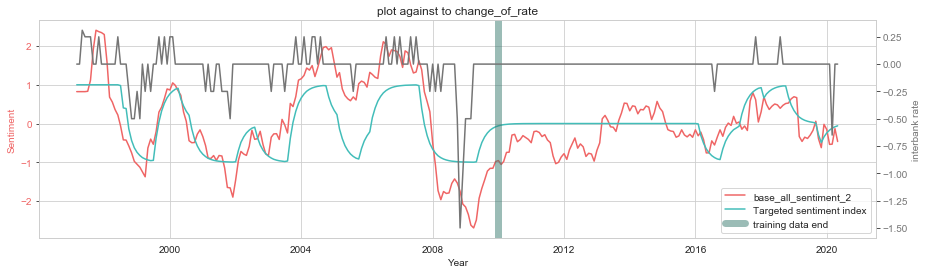

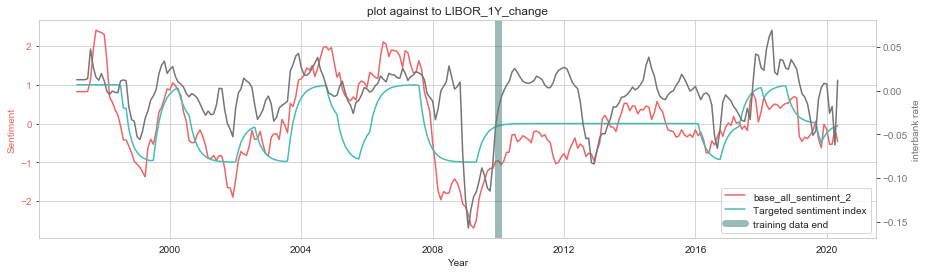

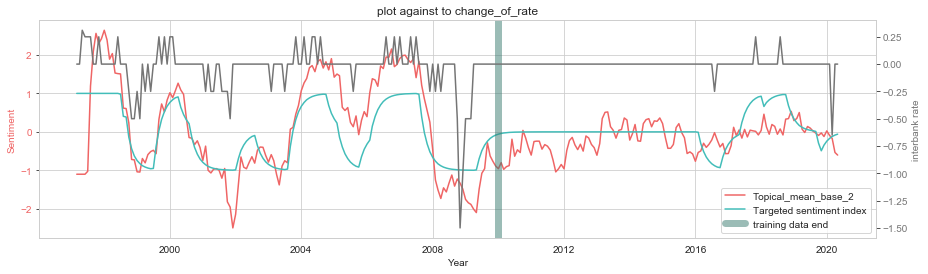

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.735950             0.733437      0.416025
LIBOR_1Y_change              0.562990             0.447420      0.345964
Interest_rate                0.300092             0.319598      0.183623
change_of_rate               0.444078             0.365622      0.371591
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.313208
base_all_sentiment         0.313208            1.000000


label   label_2  \
label                                            1.000000  0.285191   
label_2                                          0.285191  1.000000   
base_all_sentiment                               0.382433  0.735950   
base_Financial markets_sentiment                 0.314987  0.777666   
base_The immediate policy decision_sentiment     0.148352  0.672105   
base_Growth and inflation projections_sentiment  0.259647  0.667859   
base_Money, credit, demand and output_sentiment  0.204221  0.538873   
base_Supply, costs and prices_sentiment          0.075631  0.326474   
base_The international economy_sentiment         0.314061  0.465059   
Topical_mean_base                                0.237869  0.733437   
FS_sentiment                                     0.193041  0.416025   
LM_sentiment                                    -0.048791 -0.103924   
LIBOR_1Y_change                                  0.325277  0.525375   
Interest_rate                                   -0.142939  0.084988   
change_of_rate                                   0.235769  0.472797   
base_all_sentiment_2                             0.382433  0.735950   
Topical_mean_base_2                              0.237869  0.733437   

                                                 base_all_sentiment  \
label                                                      0.382433   
label_2                                                    0.735950   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.850057   
base_The immediate policy decision_sentiment               0.761083   
base_Growth and inflation projections_sentiment            0.803316   
base_Money, credit, demand and output_sentiment            0.653452   
base_Supply, costs and prices_sentiment                    0.500236   
base_The international economy_sentiment                   0.584565   
Topical_mean_base                                          0.887835   
FS_sentiment                                               0.607356   
LM_sentiment                                               0.108563   
LIBOR_1Y_change                                            0.562990   
Interest_rate                                              0.300092   
change_of_rate                                             0.444078   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.887835   

                                                 base_Financial markets_sentiment  \
label                                                                    0.314987   
label_2                                                                  0.777666   
base_all_sentiment                                                       0.850057   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.643808   
base_Growth and inflation projections_sentiment                          0.716068   
base_Money, credit, demand and output_sentiment                          0.541511   
base_Supply, costs and prices_sentiment                                  0.481457   
base_The international economy_sentiment                                 0.483707   
Topical_mean_base                                                        0.842397   
FS_sentiment                                                             0.521110   
LM_sentiment                                                            -0.055579   
LIBOR_1Y_change                                                          0.482904   
Interest_rate                                                            0.218914   
change_of_rate                                                           0.425247   
base_all_sentiment_2                                                     0.850057   
Topical_mean_base_2                              

In [27]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_merged_prob = result_dictionary_sentiment_prob(model2,interested_topics,merged_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_merged_prob,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

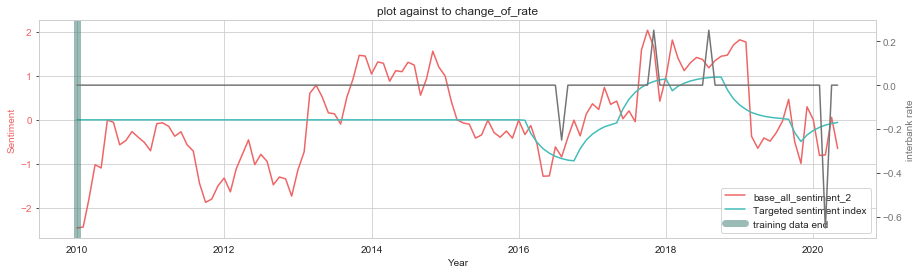

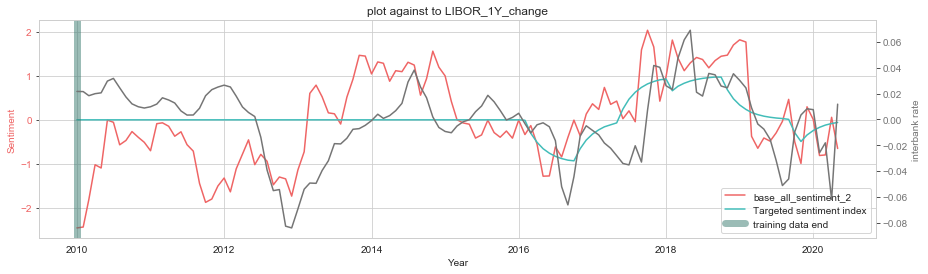

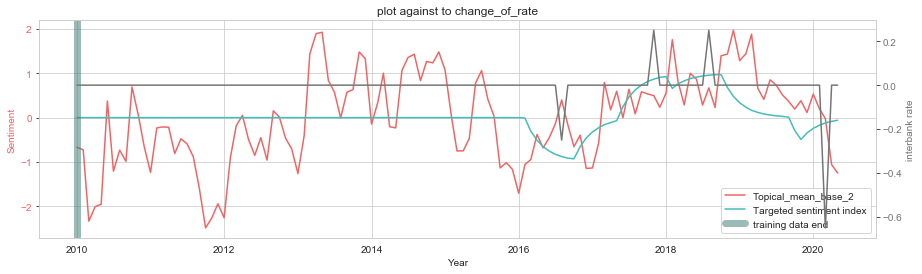

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.494988             0.305103      0.181010
LIBOR_1Y_change              0.247988             0.008679     -0.054334
Interest_rate               -0.014622             0.263899      0.012932
change_of_rate               0.164772             0.023757      0.015814
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.313208
base_all_sentiment         0.313208            1.000000


label   label_2  \
label                                            1.000000  0.379603   
label_2                                          0.379603  1.000000   
base_all_sentiment                               0.257775  0.494988   
base_Financial markets_sentiment                 0.039836  0.319546   
base_The immediate policy decision_sentiment     0.099240  0.143431   
base_Growth and inflation projections_sentiment -0.175701  0.246110   
base_Money, credit, demand and output_sentiment  0.255431  0.425895   
base_Supply, costs and prices_sentiment         -0.068021 -0.079151   
base_The international economy_sentiment         0.196947  0.432010   
Topical_mean_base                                0.031242  0.305103   
FS_sentiment                                     0.199694  0.181010   
LM_sentiment                                    -0.154466  0.194132   
LIBOR_1Y_change                                  0.412518  0.439206   
Interest_rate                                   -0.257833  0.105995   
change_of_rate                                   0.083936  0.234792   
base_all_sentiment_2                             0.257775  0.494988   
Topical_mean_base_2                              0.031242  0.305103   

                                                 base_all_sentiment  \
label                                                      0.257775   
label_2                                                    0.494988   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.535418   
base_The immediate policy decision_sentiment               0.471870   
base_Growth and inflation projections_sentiment            0.567543   
base_Money, credit, demand and output_sentiment            0.394691   
base_Supply, costs and prices_sentiment                   -0.056441   
base_The international economy_sentiment                   0.238705   
Topical_mean_base                                          0.691164   
FS_sentiment                                               0.606534   
LM_sentiment                                               0.406504   
LIBOR_1Y_change                                            0.247988   
Interest_rate                                             -0.014622   
change_of_rate                                             0.164772   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.691164   

                                                 base_Financial markets_sentiment  \
label                                                                    0.039836   
label_2                                                                  0.319546   
base_all_sentiment                                                       0.535418   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                            -0.018553   
base_Growth and inflation projections_sentiment                          0.513825   
base_Money, credit, demand and output_sentiment                          0.071874   
base_Supply, costs and prices_sentiment                                 -0.049434   
base_The international economy_sentiment                                 0.279071   
Topical_mean_base                                                        0.569537   
FS_sentiment                                                             0.400928   
LM_sentiment                                                             0.110091   
LIBOR_1Y_change                                                         -0.096626   
Interest_rate                                                            0.177060   
change_of_rate                                                          -0.013434   
base_all_sentiment_2                                                     0.535418   
Topical_mean_base_2                              

In [36]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_merged_prob = result_dictionary_sentiment_prob(model2,interested_topics,merged_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_merged_prob,start=end_date,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

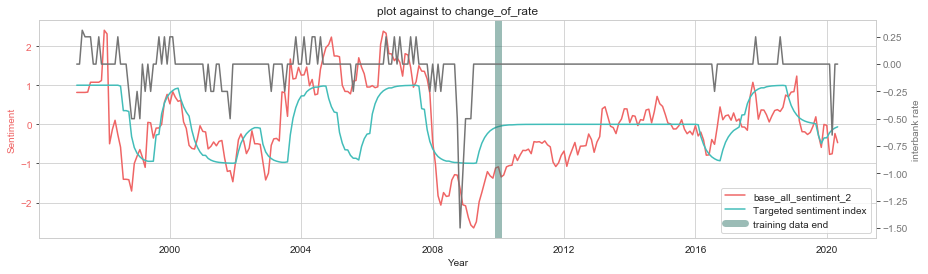

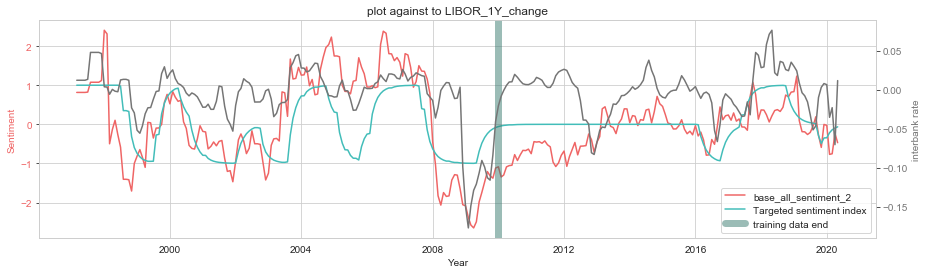

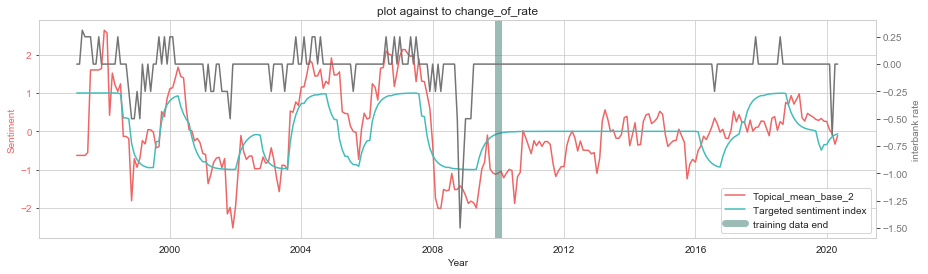

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.602749             0.708923      0.267591
LIBOR_1Y_change              0.510730             0.469350      0.278078
Interest_rate                0.255606             0.265047      0.246324
change_of_rate               0.399201             0.374845      0.216922
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.261218
base_all_sentiment         0.261218            1.000000


label   label_2  \
label                                            1.000000  0.269144   
label_2                                          0.269144  1.000000   
base_all_sentiment                               0.327486  0.602749   
base_Financial markets_sentiment                 0.217397  0.693085   
base_The immediate policy decision_sentiment     0.133653  0.624998   
base_Growth and inflation projections_sentiment  0.267256  0.635319   
base_Money, credit, demand and output_sentiment  0.043876  0.165373   
base_Supply, costs and prices_sentiment          0.040415  0.107760   
base_The international economy_sentiment         0.106797  0.087307   
Topical_mean_base                                0.204222  0.708923   
FS_sentiment                                     0.049679  0.267591   
LM_sentiment                                    -0.037124 -0.008321   
LIBOR_1Y_change                                  0.313913  0.556395   
Interest_rate                                   -0.150237  0.099403   
change_of_rate                                   0.223049  0.465049   
base_all_sentiment_2                             0.327486  0.602749   
Topical_mean_base_2                              0.204222  0.708923   

                                                 base_all_sentiment  \
label                                                      0.327486   
label_2                                                    0.602749   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.757761   
base_The immediate policy decision_sentiment               0.584181   
base_Growth and inflation projections_sentiment            0.766912   
base_Money, credit, demand and output_sentiment            0.189335   
base_Supply, costs and prices_sentiment                    0.332255   
base_The international economy_sentiment                   0.272545   
Topical_mean_base                                          0.823346   
FS_sentiment                                               0.541839   
LM_sentiment                                               0.122427   
LIBOR_1Y_change                                            0.510730   
Interest_rate                                              0.255606   
change_of_rate                                             0.399201   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.823346   

                                                 base_Financial markets_sentiment  \
label                                                                    0.217397   
label_2                                                                  0.693085   
base_all_sentiment                                                       0.757761   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.432266   
base_Growth and inflation projections_sentiment                          0.639789   
base_Money, credit, demand and output_sentiment                          0.146771   
base_Supply, costs and prices_sentiment                                  0.309485   
base_The international economy_sentiment                                 0.176660   
Topical_mean_base                                                        0.798242   
FS_sentiment                                                             0.538412   
LM_sentiment                                                             0.129353   
LIBOR_1Y_change                                                          0.466206   
Interest_rate                                                            0.281414   
change_of_rate                                                           0.415341   
base_all_sentiment_2                                                     0.757761   
Topical_mean_base_2                              

In [34]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_speech_prob = result_dictionary_sentiment_prob(model2,interested_topics,speech_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_speech_prob,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

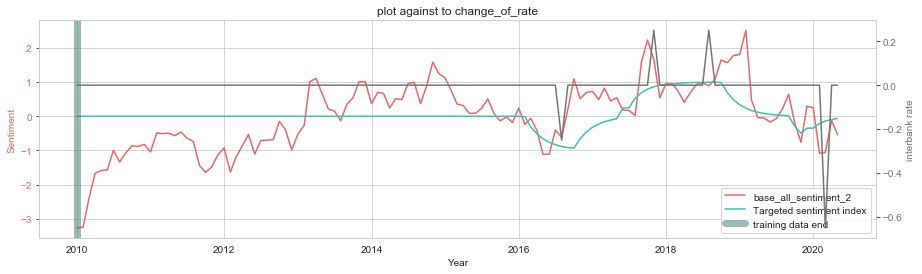

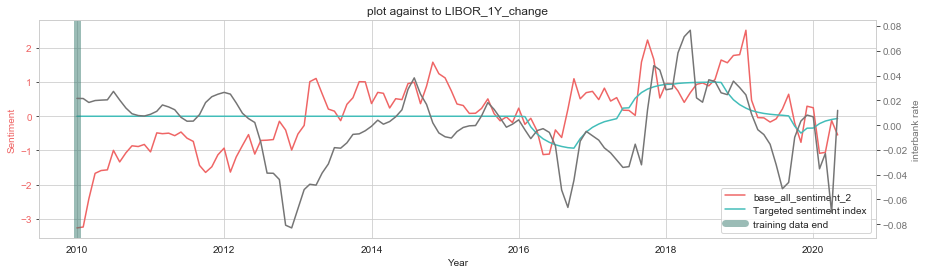

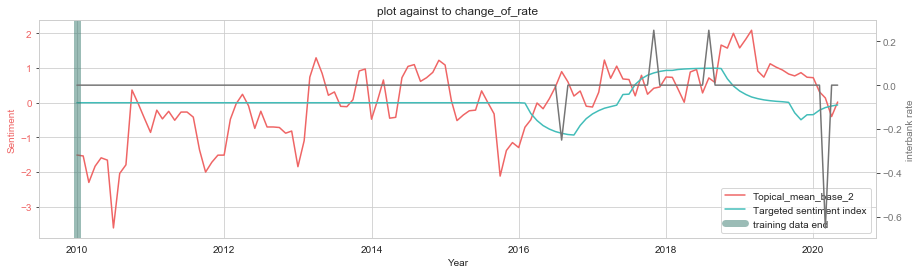

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.368677             0.182995      0.064535
LIBOR_1Y_change              0.036124            -0.029134     -0.155913
Interest_rate               -0.021306             0.198222      0.101133
change_of_rate               0.169426            -0.003480     -0.049088
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.261218
base_all_sentiment         0.261218            1.000000


label   label_2  \
label                                            1.000000  0.372007   
label_2                                          0.372007  1.000000   
base_all_sentiment                              -0.064080  0.368677   
base_Financial markets_sentiment                -0.149093  0.066816   
base_The immediate policy decision_sentiment     0.084656  0.183588   
base_Growth and inflation projections_sentiment -0.173261  0.254104   
base_Money, credit, demand and output_sentiment  0.336498  0.497032   
base_Supply, costs and prices_sentiment         -0.150677 -0.059302   
base_The international economy_sentiment         0.001011  0.174082   
Topical_mean_base                               -0.131298  0.182995   
FS_sentiment                                    -0.084571  0.064535   
LM_sentiment                                    -0.208078  0.212827   
LIBOR_1Y_change                                  0.403818  0.498816   
Interest_rate                                   -0.258164  0.113768   
change_of_rate                                   0.082637  0.232729   
base_all_sentiment_2                            -0.064080  0.368677   
Topical_mean_base_2                             -0.131298  0.182995   

                                                 base_all_sentiment  \
label                                                     -0.064080   
label_2                                                    0.368677   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.616690   
base_The immediate policy decision_sentiment               0.463627   
base_Growth and inflation projections_sentiment            0.703564   
base_Money, credit, demand and output_sentiment            0.229837   
base_Supply, costs and prices_sentiment                    0.074178   
base_The international economy_sentiment                   0.276772   
Topical_mean_base                                          0.709748   
FS_sentiment                                               0.573213   
LM_sentiment                                               0.537655   
LIBOR_1Y_change                                            0.036124   
Interest_rate                                             -0.021306   
change_of_rate                                             0.169426   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.709748   

                                                 base_Financial markets_sentiment  \
label                                                                   -0.149093   
label_2                                                                  0.066816   
base_all_sentiment                                                       0.616690   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                            -0.045381   
base_Growth and inflation projections_sentiment                          0.685146   
base_Money, credit, demand and output_sentiment                          0.001052   
base_Supply, costs and prices_sentiment                                  0.136647   
base_The international economy_sentiment                                 0.615450   
Topical_mean_base                                                        0.589982   
FS_sentiment                                                             0.595571   
LM_sentiment                                                             0.503444   
LIBOR_1Y_change                                                         -0.180975   
Interest_rate                                                            0.264839   
change_of_rate                                                          -0.055445   
base_all_sentiment_2                                                     0.616690   
Topical_mean_base_2                              

In [35]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_speech_prob = result_dictionary_sentiment_prob(model2,interested_topics,speech_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_speech_prob,start=end_date,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

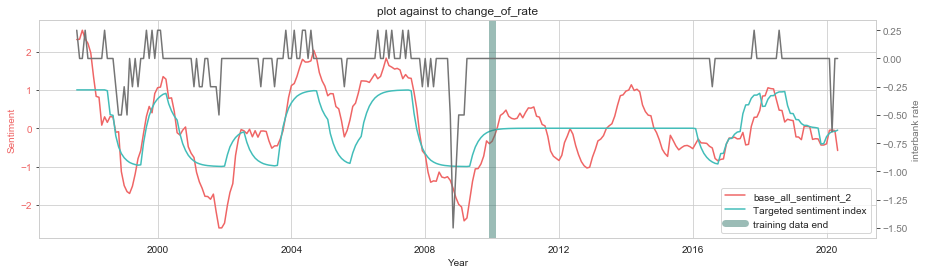

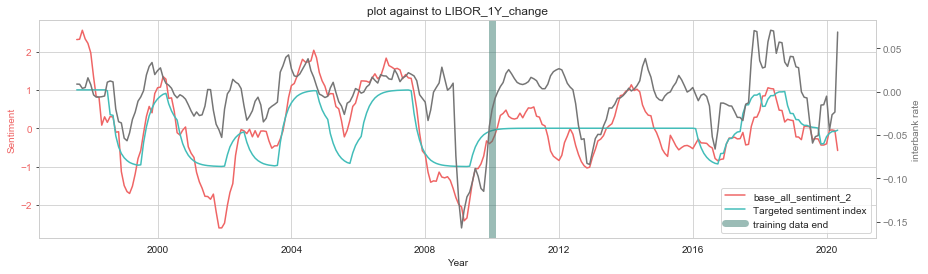

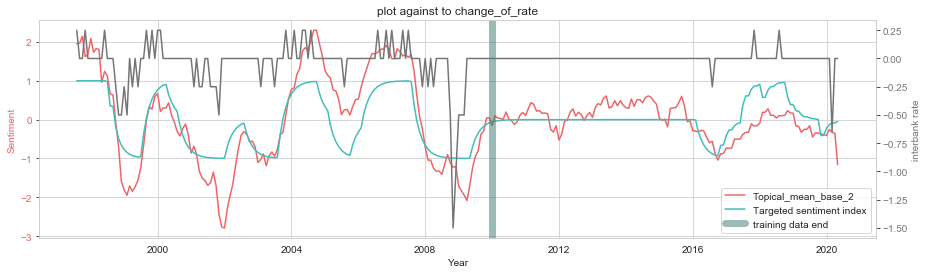

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.793165             0.815898      0.468615
LIBOR_1Y_change              0.552355             0.431535      0.344706
Interest_rate                0.194281             0.161158      0.251038
change_of_rate               0.453803             0.426963      0.404202
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.385299
base_all_sentiment         0.385299            1.000000


label   label_2  \
label                                            1.000000  0.280315   
label_2                                          0.280315  1.000000   
base_all_sentiment                               0.446957  0.793165   
base_Financial markets_sentiment                 0.390894  0.736912   
base_The immediate policy decision_sentiment     0.198659  0.777484   
base_Growth and inflation projections_sentiment  0.227188  0.612586   
base_Money, credit, demand and output_sentiment  0.232092  0.690074   
base_Supply, costs and prices_sentiment          0.209527  0.748905   
base_The international economy_sentiment         0.343372  0.730717   
Topical_mean_base                                0.291882  0.815898   
FS_sentiment                                     0.396924  0.468615   
LM_sentiment                                     0.064578 -0.073601   
LIBOR_1Y_change                                  0.326703  0.529599   
Interest_rate                                   -0.138337  0.053877   
change_of_rate                                   0.235063  0.462235   
base_all_sentiment_2                             0.446957  0.793165   
Topical_mean_base_2                              0.291882  0.815898   

                                                 base_all_sentiment  \
label                                                      0.446957   
label_2                                                    0.793165   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.745362   
base_The immediate policy decision_sentiment               0.865252   
base_Growth and inflation projections_sentiment            0.688468   
base_Money, credit, demand and output_sentiment            0.755813   
base_Supply, costs and prices_sentiment                    0.733567   
base_The international economy_sentiment                   0.771390   
Topical_mean_base                                          0.903491   
FS_sentiment                                               0.678088   
LM_sentiment                                               0.134980   
LIBOR_1Y_change                                            0.552355   
Interest_rate                                              0.194281   
change_of_rate                                             0.453803   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.903491   

                                                 base_Financial markets_sentiment  \
label                                                                    0.390894   
label_2                                                                  0.736912   
base_all_sentiment                                                       0.745362   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.729272   
base_Growth and inflation projections_sentiment                          0.501358   
base_Money, credit, demand and output_sentiment                          0.593520   
base_Supply, costs and prices_sentiment                                  0.804834   
base_The international economy_sentiment                                 0.734542   
Topical_mean_base                                                        0.813984   
FS_sentiment                                                             0.361483   
LM_sentiment                                                            -0.250556   
LIBOR_1Y_change                                                          0.401996   
Interest_rate                                                           -0.096935   
change_of_rate                                                           0.388684   
base_all_sentiment_2                                                     0.745362   
Topical_mean_base_2                              

In [32]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_minutes_prob = result_dictionary_sentiment_prob(model2,interested_topics,minutes_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_minutes_prob,start=start_date,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

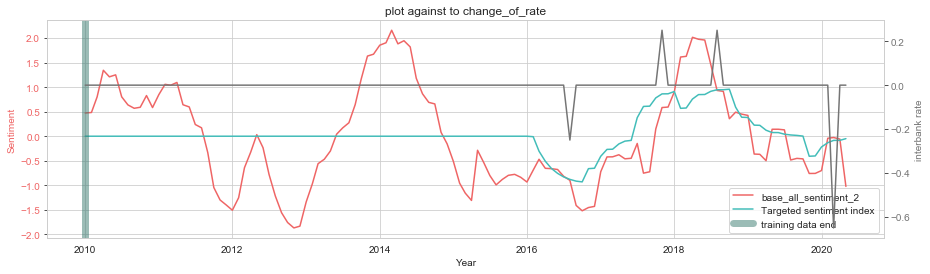

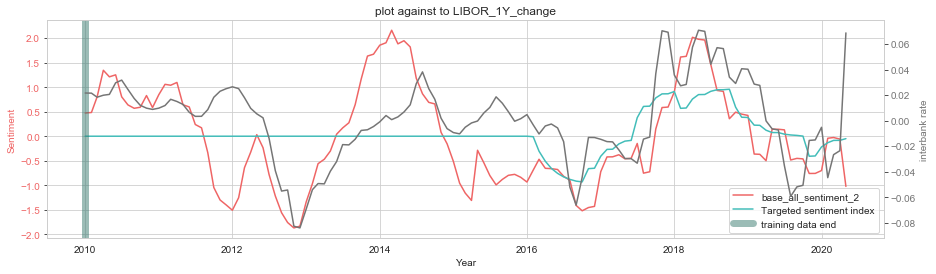

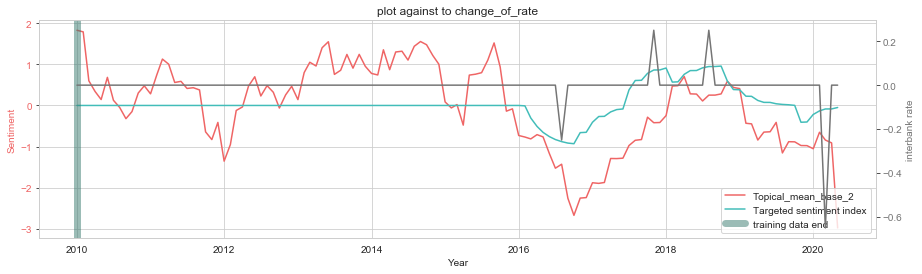

Correlation with Averaging
                 base_all_sentiment_2  Topical_mean_base_2  FS_sentiment
label_2                      0.448804             0.343100      0.266246
LIBOR_1Y_change              0.531277             0.196292      0.279012
Interest_rate                0.134808             0.281051     -0.268816
change_of_rate               0.071253             0.098850      0.084684
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.385299
base_all_sentiment         0.385299            1.000000


label   label_2  \
label                                            1.000000  0.348366   
label_2                                          0.348366  1.000000   
base_all_sentiment                               0.662676  0.448804   
base_Financial markets_sentiment                 0.202982  0.528730   
base_The immediate policy decision_sentiment     0.184055  0.102214   
base_Growth and inflation projections_sentiment -0.023141  0.131748   
base_Money, credit, demand and output_sentiment  0.002475  0.033410   
base_Supply, costs and prices_sentiment          0.154561  0.214553   
base_The international economy_sentiment         0.324275  0.556163   
Topical_mean_base                                0.293663  0.343100   
FS_sentiment                                     0.747305  0.266246   
LM_sentiment                                     0.362806 -0.031255   
LIBOR_1Y_change                                  0.398065  0.558244   
Interest_rate                                   -0.231922  0.164373   
change_of_rate                                   0.072061  0.232512   
base_all_sentiment_2                             0.662676  0.448804   
Topical_mean_base_2                              0.293663  0.343100   

                                                 base_all_sentiment  \
label                                                      0.662676   
label_2                                                    0.448804   
base_all_sentiment                                         1.000000   
base_Financial markets_sentiment                           0.356365   
base_The immediate policy decision_sentiment               0.427555   
base_Growth and inflation projections_sentiment            0.342128   
base_Money, credit, demand and output_sentiment            0.024285   
base_Supply, costs and prices_sentiment                   -0.024874   
base_The international economy_sentiment                   0.565010   
Topical_mean_base                                          0.522958   
FS_sentiment                                               0.759098   
LM_sentiment                                               0.335034   
LIBOR_1Y_change                                            0.531277   
Interest_rate                                              0.134808   
change_of_rate                                             0.071253   
base_all_sentiment_2                                       1.000000   
Topical_mean_base_2                                        0.522958   

                                                 base_Financial markets_sentiment  \
label                                                                    0.202982   
label_2                                                                  0.528730   
base_all_sentiment                                                       0.356365   
base_Financial markets_sentiment                                         1.000000   
base_The immediate policy decision_sentiment                             0.040321   
base_Growth and inflation projections_sentiment                          0.157876   
base_Money, credit, demand and output_sentiment                         -0.013859   
base_Supply, costs and prices_sentiment                                  0.341165   
base_The international economy_sentiment                                 0.230079   
Topical_mean_base                                                        0.428662   
FS_sentiment                                                             0.361754   
LM_sentiment                                                            -0.003477   
LIBOR_1Y_change                                                          0.140972   
Interest_rate                                                           -0.151711   
change_of_rate                                                           0.101483   
base_all_sentiment_2                                                     0.356365   
Topical_mean_base_2                              

In [33]:
end_date, start_date='2009-12-31','1997-08-01'
#sentiment_97_10_minutes_prob = result_dictionary_sentiment_prob(model2,interested_topics,minutes_timeseries_labelled)
result,result2 = rolling_averaging_ewm(sentiment_97_10_minutes_prob,start=end_date,end ='2020-06-28')
visualise_prob_model(result)
print('Correlation with Averaging')
print(result.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','Topical_mean_base_2','FS_sentiment']])
print('Correlation No Averaging')
print(result2.corr())
result.corr()

## Step 3: ML based sentiments

In [260]:
result = []
for doc_list in merged_timeseries_labelled.loc[:,'N_topics']:
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    result.append(document)
merged_timeseries_labelled.loc[:,'cleaned'] = result
merged_timeseries_labelled.loc[:,'cleaned'] = preprocess_data(list(merged_timeseries_labelled.loc[:,'cleaned']))
#merged_timeseries_labelled = pd.read_hdf('regression_data.h5', 'minutes')
word_list = list(dictionary_model_97_15_merged[0].loc[:,'Entry'])
merged_timeseries_labelled.loc[:,'cleaned string'] = merged_timeseries_labelled.loc[:,'cleaned'].apply(lambda x: ' '.join([i for i in x if i in word_list]))
merged_timeseries_labelled_backup = merged_timeseries_labelled.copy()

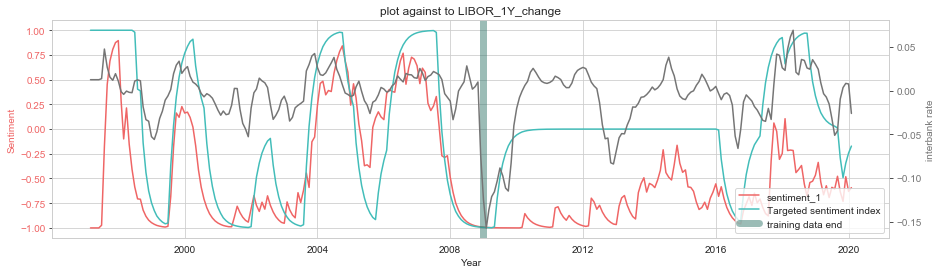

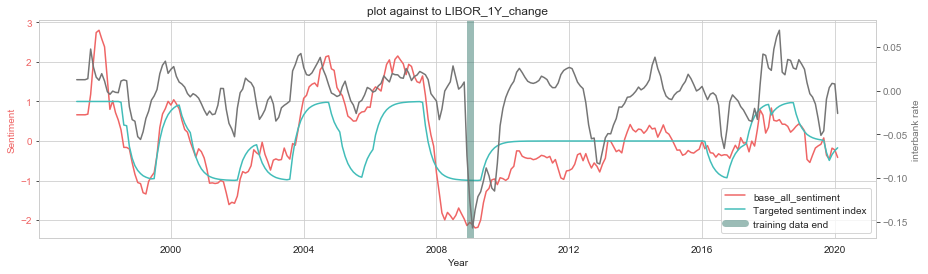

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.638763            0.776956
LIBOR_1Y_change     0.434594            0.525016
Interest_rate       0.382822            0.299896
change_of_rate      0.313431            0.466388
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.304985
base_all_sentiment         0.304985            1.000000


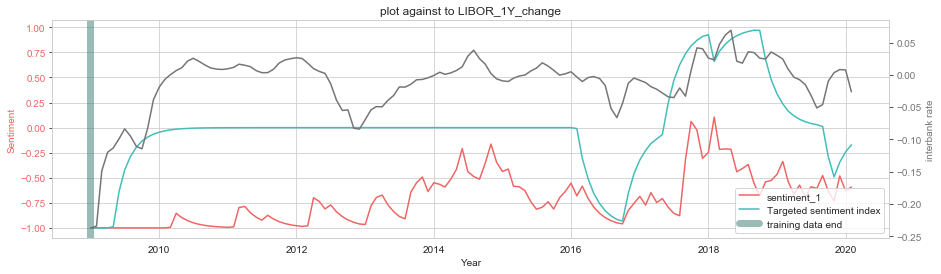

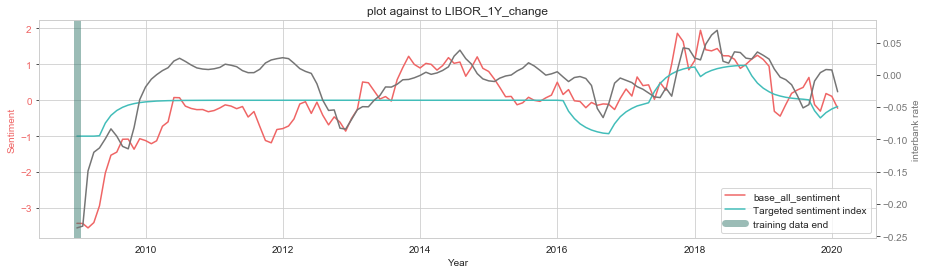

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.579357            0.672635
LIBOR_1Y_change     0.456830            0.715790
Interest_rate      -0.065848           -0.384683
change_of_rate      0.265646            0.533309
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.304985
base_all_sentiment         0.304985            1.000000


In [273]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


end_date='2008-12-31'
def train_multiNB(merged_timeseries_labelled,end_date):
    X_train = merged_timeseries_labelled.loc[end_date:,'cleaned string']
    X_test = merged_timeseries_labelled.loc[:end_date,'cleaned string']
    y_train = merged_timeseries_labelled.loc[end_date:,'label_2']
    y_test = merged_timeseries_labelled.loc[:end_date,'label_2']


    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB()),
                         ])



    text_clf.fit(X_train, y_train)
    predicted_train = text_clf.predict(X_train)
    predicted_test = text_clf.predict(X_test)
    merged_timeseries_labelled.loc[:,'sentiment_1'] = list(predicted_test)+list(predicted_train)

    predicted_train_prob = text_clf.predict_proba(X_train)
    predicted_train_prob = [i[2]-i[0] for i in predicted_train_prob]
    predicted_test_prob = text_clf.predict_proba(X_test)
    predicted_test_prob = [i[2]-i[0] for i in predicted_test_prob]
    merged_timeseries_labelled.loc[:,'base_all_sentiment'] = predicted_test_prob + predicted_train_prob



    result_NB,result_NB2 = rolling_averaging_ewm(merged_timeseries_labelled.loc[:,['label_2','sentiment_1','base_all_sentiment']])
    result_NB.loc[:,'base_all_sentiment'] = (result_NB.loc[:,'base_all_sentiment']-result_NB.loc[:,'base_all_sentiment'].mean())/np.std(result_NB.loc[:,'base_all_sentiment'])
    create_comparison_plot(result_NB,'sentiment_1',rate = 'LIBOR_1Y_change', end_date=end_date)
    create_comparison_plot(result_NB,'base_all_sentiment',rate = 'LIBOR_1Y_change', end_date=end_date)
    print('Correlation with Averaging')
    print(result_NB.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['sentiment_1','base_all_sentiment']])
    print('Correlation No Averaging')
    print(result_NB2.corr())



    result_NB,result_NB2 = rolling_averaging_ewm(merged_timeseries_labelled.loc[:,['label_2','sentiment_1','base_all_sentiment']],start=end_date)
    result_NB.loc[:,'base_all_sentiment'] = (result_NB.loc[:,'base_all_sentiment']-result_NB.loc[:,'base_all_sentiment'].mean())/np.std(result_NB.loc[:,'base_all_sentiment'])
    create_comparison_plot(result_NB,'sentiment_1',rate = 'LIBOR_1Y_change', end_date=end_date)
    create_comparison_plot(result_NB,'base_all_sentiment',rate = 'LIBOR_1Y_change', end_date=end_date)

    print('Correlation with Averaging')
    print(result_NB.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['sentiment_1','base_all_sentiment']])
    print('Correlation No Averaging')
    print(result_NB2.corr())
    return None
train_multiNB(merged_timeseries_labelled,end_date='2008-12-31')

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


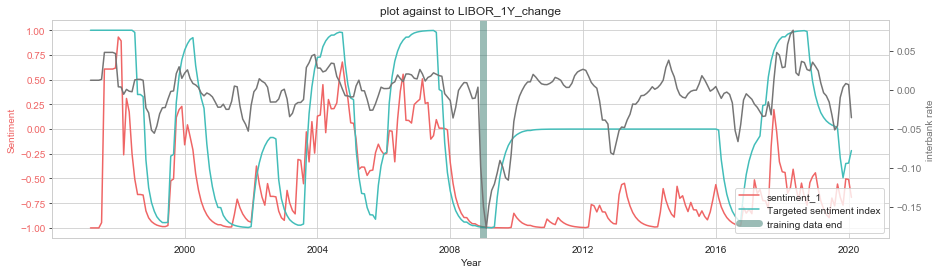

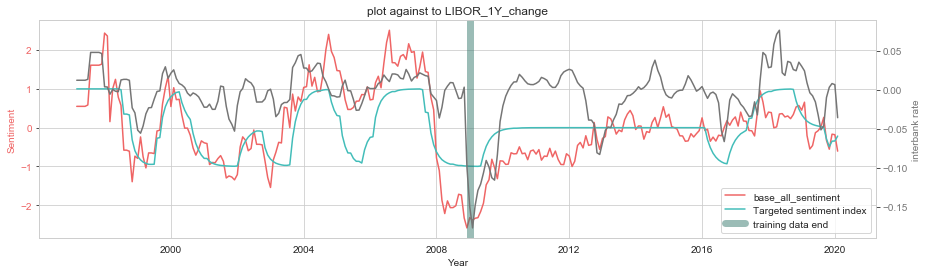

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.611094            0.718678
LIBOR_1Y_change     0.413303            0.510593
Interest_rate       0.479865            0.285498
change_of_rate      0.288648            0.462608
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.234854
base_all_sentiment         0.234854            1.000000


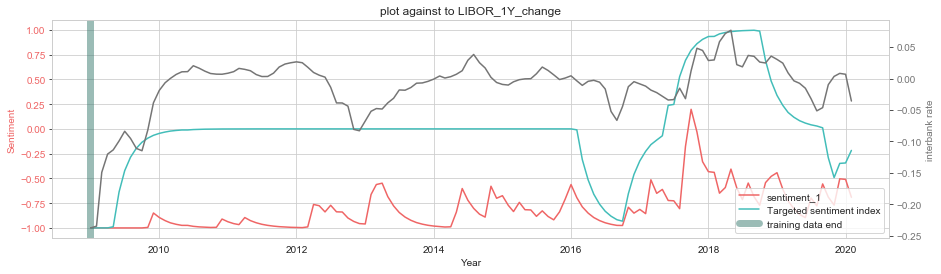

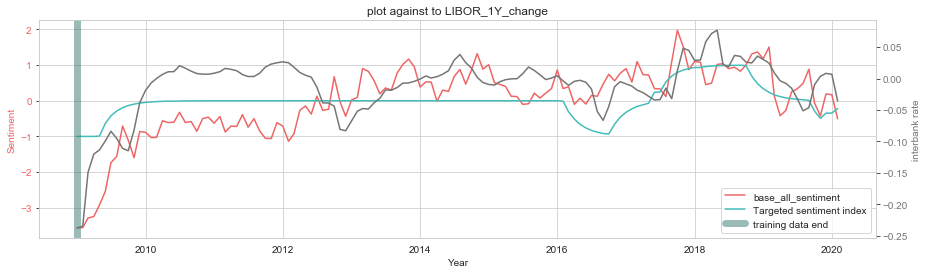

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.567729            0.566372
LIBOR_1Y_change     0.325502            0.616368
Interest_rate      -0.120414           -0.426539
change_of_rate      0.259380            0.519688
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.234854
base_all_sentiment         0.234854            1.000000


In [267]:
train_multiNB(merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Speech',:],end_date)

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


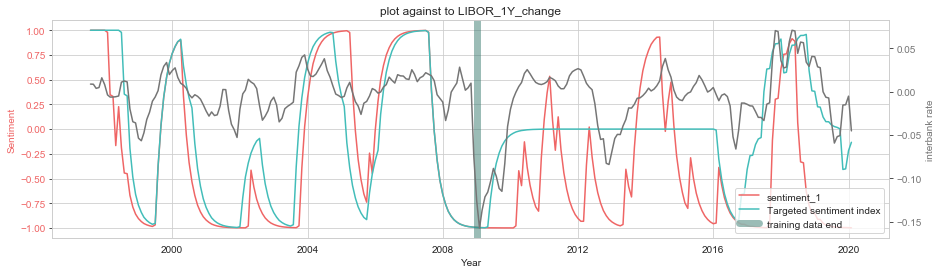

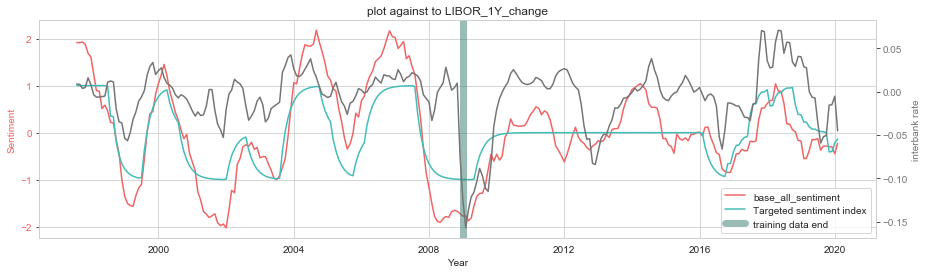

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.725779            0.847322
LIBOR_1Y_change     0.501218            0.516288
Interest_rate       0.286880            0.135289
change_of_rate      0.337463            0.471180
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.338754
base_all_sentiment         0.338754            1.000000


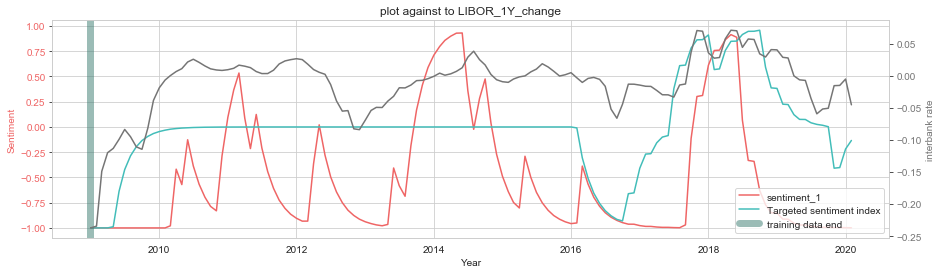

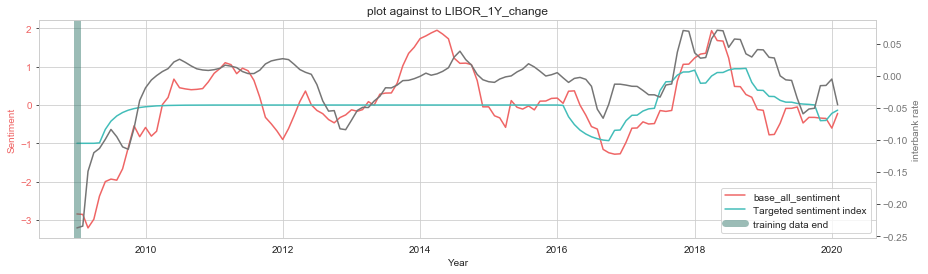

Correlation with Averaging
                 sentiment_1  base_all_sentiment
label_2             0.423771            0.628874
LIBOR_1Y_change     0.484506            0.730411
Interest_rate      -0.125550           -0.293818
change_of_rate      0.164858            0.449028
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.338754
base_all_sentiment         0.338754            1.000000


In [270]:
train_multiNB(merged_timeseries_labelled.loc[merged_timeseries_labelled.loc[:,'Type']=='Minutes',:],end_date)

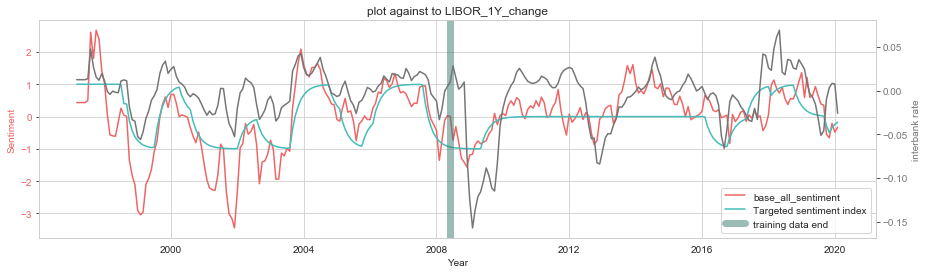

Correlation with Averaging
                 base_all_sentiment
label_2                    0.685230
LIBOR_1Y_change            0.509662
Interest_rate             -0.214512
change_of_rate             0.482841
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.335009
base_all_sentiment         0.335009            1.000000


In [181]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

end_date='2008-05-31'
merged_timeseries_labelled_rate = merged_timeseries_labelled.copy()
merged_dataset.loc[:,'LIBOR_1Y_change'] = [np.nan]+list((merged_dataset.LIBOR_1Y.values[1:] - merged_dataset.LIBOR_1Y.values[:-1])/merged_dataset.LIBOR_1Y.values[:-1])
merged_timeseries_labelled_rate = merged_timeseries_labelled_rate.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner').dropna()


X_train = merged_timeseries_labelled_rate.loc[:end_date,'cleaned string']
X_test = merged_timeseries_labelled_rate.loc[end_date:,'cleaned string']
y_train = merged_timeseries_labelled_rate.loc[:end_date,'LIBOR_1Y_change']
y_test = merged_timeseries_labelled_rate.loc[end_date:,'LIBOR_1Y_change']


text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     #('clf', RandomForestRegressor(n_estimators=10,random_state=0)),
                     ('clf', Ridge(alpha=0.5)),
                     ])



text_clf.fit(X_train, y_train)

predicted_train_prob = text_clf.predict(X_train)
predicted_test_prob = text_clf.predict(X_test)
merged_timeseries_labelled_rate.loc[:,'base_all_sentiment'] = list(predicted_train_prob)+list(predicted_test_prob)



result_NB,result_NB2 = rolling_averaging_ewm(merged_timeseries_labelled_rate.loc[:,['label_2','base_all_sentiment']])
result_NB.loc[:,'base_all_sentiment'] = (result_NB.loc[:,'base_all_sentiment']-result_NB.loc[:,'base_all_sentiment'].mean())/np.std(result_NB.loc[:,'base_all_sentiment'])
create_comparison_plot(result_NB,'base_all_sentiment',rate = 'LIBOR_1Y_change', end_date=end_date)
print('Correlation with Averaging')
print(result_NB.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment']])
print('Correlation No Averaging')
print(result_NB2.corr())


In [ ]:
# word_df = dictionary_model_97_15_merged[0].set_index('Entry')
# d1,d2,d3=[],[],[]
# for n,i in enumerate(vectorizer.get_feature_names()):
#     d1.append([text_clf.coef_[0][n],i,word_df.loc[i].values[0]])
#     d2.append([text_clf.coef_[1][n],i,word_df.loc[i].values[0]])
#     d3.append([text_clf.coef_[2][n],i,word_df.loc[i].values[0]])

In [183]:
merged_timeseries_labelled_rate

title  \
1997-03-01  Speech by Edward George for the 3rd Euromoney ...   
1997-07-01      Lord Mayors Banquet - speech by Edward George   
1997-07-01  The Sixteenth Mais Lecture - speech by Edward ...   
1997-08-01  Minutes of the MPC Meeting held on 5 and 6 Jun...   
1997-09-01  Minutes of the MPC Meeting held on 9 and 10 Ju...   
...                                                       ...   
2020-04-01       Bank Rate maintained at 01% - March 2020_1st   
2020-04-01  The grand unifying theory (and practice) of ma...   
2020-04-01  Inflation and beliefs about inflation - speech...   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-05-01  Monetary policy and the Bank of England’s bala...   

                                                     N_topics     Type  label  \
1997-03-01  [[Financial markets, One concern at the time w...   Speech      0   
1997-07-01  [[Financial markets, It operates with long and...   Speech      0   
1997-07-01  [[Financial markets, Sweeping generalisations ...   Speech      0   
1997-08-01  [[Financial markets, Short-term interest rates...  Minutes      0   
1997-09-01  [[Financial markets, The estimated change in n...  Minutes      0   
...                                                       ...      ...    ...   
2020-04-01  [[Growth and inflation projections, The Bank o...  Minutes      0   
2020-04-01  [[Financial markets, Macroprudential policy is...   Speech      0   
2020-04-01  [[Financial markets, Precisely for that reason...   Speech      0   
2020-05-01  [[Financial markets, Second, the policy respon...   Speech      0   
2020-05-01  [[Financial markets, It is far more complex th...   Speech      0   

            label_2                                            cleaned  \
1997-03-01        1  [one, concern, time, face, global, capit, shor...   
1997-07-01        1  [oper, long, unpredict, time, lag, necessarili...   
1997-07-01        1  [sweep, generalis, cours, alway, danger, parti...   
1997-08-01        1  [short, term, interest, rate, expect, next, co...   
1997-09-01        1  [estim, chang, note, coin, may, revis, upward,...   
...             ...                                                ...   
2020-04-01        0  [bank, england, monetari, polici, committe, mp...   
2020-04-01        0  [macroprudenti, polici, core, respons, central...   
2020-04-01        0  [precis, reason, may, therefor, role, econom, ...   
2020-05-01        0  [second, polici, respons, mpc, make, one, part...   
2020-05-01        0  [far, complex, consequ, far, scope, activ, pol...   

                                               cleaned string  sentiment_1  \
1997-03-01  shortag strengthen remark someth worsen macro ...           -1   
1997-07-01  lag strain upon principl technic implement pre...            1   
1997-07-01  danger away macro macro respond damag good lif...           -1   
1997-08-01  grow grow evolv summer grow difficult problem ...            1   
1997-09-01  upward weaken broad strengthen wholesal broad ...            1   
...                                                       ...          ...   
2020-04-01  challeng respond sever disrupt contain evolv s...           -1   
2020-04-01  better improv improv prolong threaten crisi re...           -1   
2020-04-01  precis ensur disrupt damag offici fast centuri...           -1   
2020-05-01  ensur failur loss persist neg expenditur diffi...           -1   
2020-05-01  social ensur sever disrupt principl sheet trea...           -1   

            sentiment_2  base_all_sentiment  LIBOR_1Y_change  
1997-03-01    -0.038892            0.005807         0.012387  
1997-07-01     0.159440            0.025449         0.056904  
1997-07-01    -0.015138            0.032292         0.056904  
1997-08-01     0.337077            0.010653         0.008657  
1997-09-01     0.518462            0.034723         0.000265  
...                 ...                 ...              ...  
2020-04-01    -0.368959           -

## Step 3: word2vec representation

In [67]:
dataset = pd.read_hdf('cleaned_all.h5', key='cleaned_all')
word_list = pd.read_hdf('cleaned_all.h5', key='word_list').words.values
dataset.head()

title  \
1997-03-01  Speech by Edward George for the 3rd Euromoney ...   
1997-07-01      Lord Mayors Banquet - speech by Edward George   
1997-07-01  The Sixteenth Mais Lecture - speech by Edward ...   
1997-08-01  Minutes of the MPC Meeting held on 5 and 6 Jun...   
1997-09-01  Minutes of the MPC Meeting held on 9 and 10 Ju...   

                                                   all_string  \
1997-03-01  honour invit open rd euromoney intern bond con...   
1997-07-01  let begin congratul chancellor overwhelm elect...   
1997-07-01  delight invit deliv sixteenth mai lectur two t...   
1997-08-01  Short-term interest rates expected over the ne...   
1997-09-01  The estimated change in notes and coin in May ...   

                                                     N_topics     Type  label  \
1997-03-01  [[Financial markets, One concern at the time w...   Speech      0   
1997-07-01  [[Financial markets, It operates with long and...   Speech      0   
1997-07-01  [[Financial markets, Sweeping generalisations ...   Speech      0   
1997-08-01  [[Financial markets, Short-term interest rates...  Minutes      0   
1997-09-01  [[Financial markets, The estimated change in n...  Minutes      0   

            label_2                                   cleaned_filtered  \
1997-03-01        1  [one, concern, time, face, global, capit, shor...   
1997-07-01        1  [oper, long, unpredict, time, lag, necessarili...   
1997-07-01        1  [sweep, generalis, cours, alway, danger, parti...   
1997-08-01        1  [short, term, interest, rate, expect, next, co...   
1997-09-01        1  [estim, chang, note, coin, may, revis, upward,...   

                                    cleaned_filtered_wordlsit  \
1997-03-01  shortag strengthen remark someth worsen macro ...   
1997-07-01  lag strain upon principl technic implement pre...   
1997-07-01  danger away macro macro respond damag good lif...   
1997-08-01  grow grow evolv summer grow difficult problem ...   
1997-09-01  upward weaken broad strengthen wholesal broad ...   

                                                  cleaned_all  \
1997-03-01  [honour, invit, open, rd, euromoney, intern, b...   
1997-07-01  [let, begin, congratul, chancellor, overwhelm,...   
1997-07-01  [delight, invit, deliv, sixteenth, mai, lectur...   
1997-08-01  [short, term, interest, rate, expect, next, co...   
1997-09-01  [estim, chang, note, coin, may, revis, upward,...   

                                         cleaned_all_wordlsit  LIBOR_1Y_change  
1997-03-01  event financ better weak enjoy shortag strengt...         0.012387  
1997-07-01  banker challeng technic implement lag strain u...         0.056904  
1997-07-01  someth introduct danger away macro macro respo...         0.056904  
1997-08-01  grow grow evolv summer grow difficult problem ...         0.008657  
1997-09-01  upward weaken broad strengthen wholesal broad ...         0.000265

In [68]:
from gensim.models import Word2Vec
word2vec = Word2Vec(dataset['cleaned_filtered'], min_count=2)


In [73]:
def show_close_word(word_list,n):
    print(word_list[n])
    print(word2vec.wv.most_similar(word_list[n]))
    return None

In [110]:
from sklearn.manifold import TSNE
model_97_10_word2vec = dictionary_model_97_10_merged[0].copy()
model_97_10_word2vec.loc[:,'vector'] = model_97_10_word2vec.loc[:,'Entry'].apply(lambda x: word2vec[x])
uncomposed = np.array([i for i in model_97_10_word2vec.loc[:,'vector']])

tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
uncomposed = tsne_model_en_2d.fit_transform(uncomposed)

C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
model_97_10_word2vec.loc[:,'vector_x'] = [i[0] for i in uncomposed]
model_97_10_word2vec.loc[:,'vector_y'] = [i[1] for i in uncomposed]
#model_97_10_word2vec = model_97_10_word2vec.set_index('Entry')
colors = ['#ef6565','#42bdb9']
colors = ['#ef6565' if i == 'Positive' else '#42bdb9' for i in model_97_10_word2vec.sentiment]

In [117]:
model_97_10_word2vec

sentiment                                             vector  \
Entry                                                                  
examin   Positive  [-0.43070737, -0.10613607, -0.12779678, -0.367...   
german   Positive  [0.3975818, -0.12239791, 0.62319005, -0.047337...   
smooth   Positive  [0.09618183, -0.0508656, -0.12523569, -0.25422...   
pension  Positive  [-0.24865797, -1.1329677, -0.2524944, -0.71247...   
pickup   Positive  [-0.37020972, -0.57419735, 0.14779554, -0.1924...   
...           ...                                                ...   
weakest  Negative  [0.014317763, 0.039350748, 0.22658034, 0.12127...   
weak     Negative  [-0.59046376, -0.12132434, 1.0427794, -0.63661...   
worri    Negative  [0.32305592, -0.018681698, -0.059534162, -0.06...   
worsen   Negative  [0.2079402, -0.4922905, -0.08265214, -0.112063...   
worst    Negative  [0.22334926, 0.16661523, 0.03316528, -0.249165...   

          vector_x   vector_y  
Entry                          
examin    3.639939  -5.692666  
german   10.112374 -13.197205  
smooth    1.341305  -9.786664  
pension  12.188814  11.315730  
pickup   -2.903062 -30.266321  
...            ...        ...  
weakest -10.803521  -6.988609  
weak     -4.101126 -30.758926  
worri    -6.438296   4.993614  
worsen    0.687377 -13.372468  
worst    -4.045073   4.327066  

[293 rows x 4 columns]

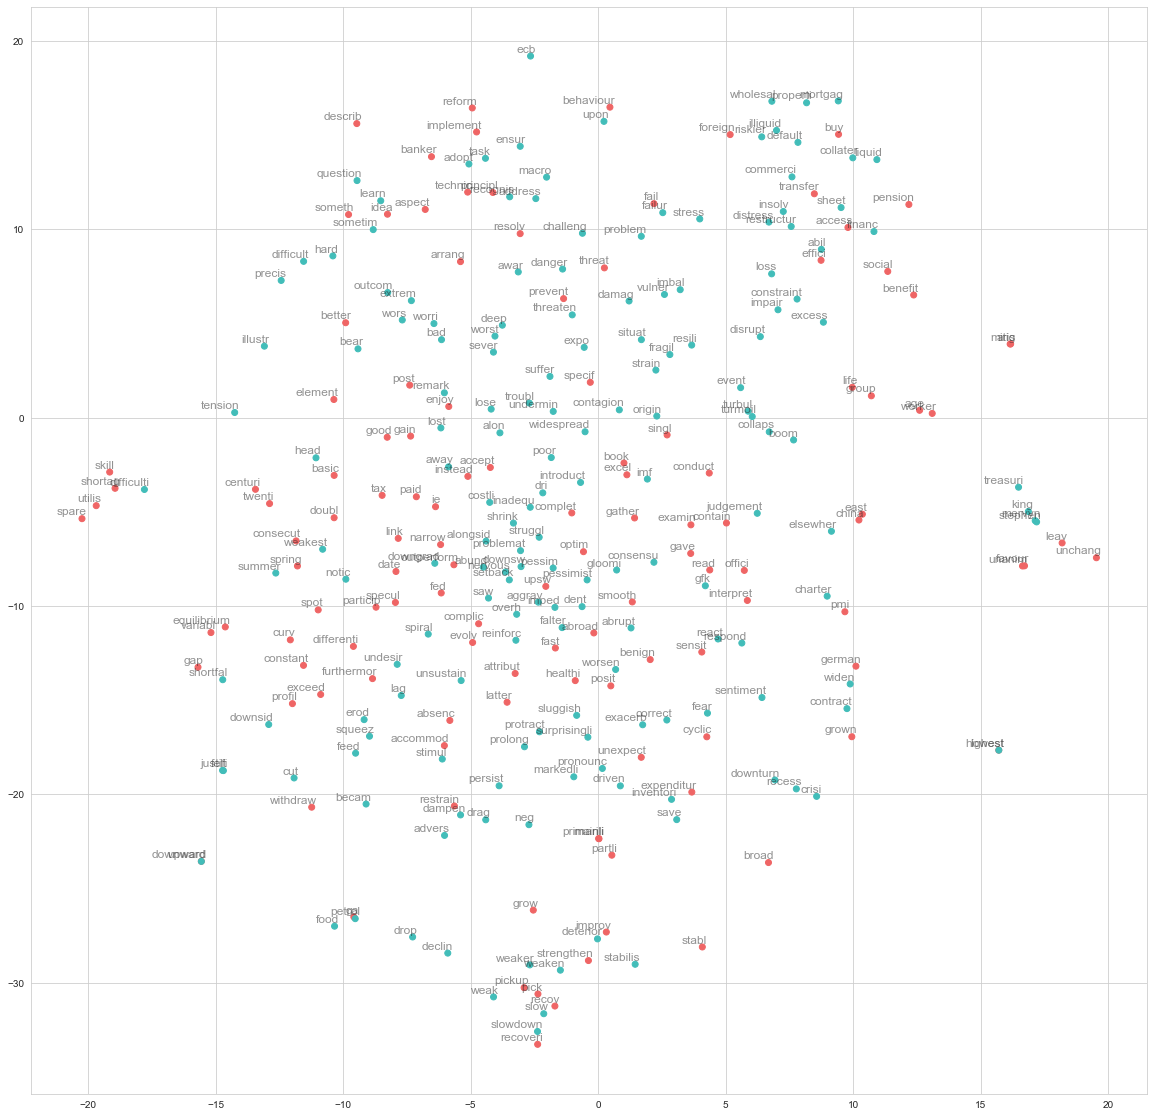

In [128]:
x = model_97_10_word2vec.loc[:,'vector_x'].values
y = model_97_10_word2vec.loc[:,'vector_y'].values
plt.figure(figsize = (20,20))
plt.scatter(x,y, c=colors,label=model_97_10_word2vec.loc[:,'sentiment'])
for i,word in enumerate(model_97_10_word2vec.index):
    plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom', size=12)


In [145]:
postive_mean = []
negative_mean = []
for i in model_97_10_word2vec.loc[model_97_10_word2vec.loc[:,'sentiment']=='Positive',:].index:
    postive_mean.append(word2vec[i])
    
for i in model_97_10_word2vec.loc[model_97_10_word2vec.loc[:,'sentiment']=='Negative',:].index:
    negative_mean.append(word2vec[i])
np.mean(postive_mean,axis=0)

C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-0.1505391 , -0.04609349,  0.10043099, -0.16159266, -0.02879535,
        0.23046221,  0.13525409, -0.00176412,  0.01670974,  0.11102404,
       -0.04732735,  0.05898103,  0.0732236 , -0.22978364,  0.10882669,
        0.2554889 , -0.33335015, -0.13262911,  0.08806691,  0.09855512,
       -0.04182723,  0.02541459,  0.16202897, -0.03750988, -0.13596392,
       -0.1389138 , -0.1408998 ,  0.09471599, -0.0536492 ,  0.11827108,
        0.00840759,  0.10103506, -0.02569284, -0.04885458, -0.01867173,
        0.03024462, -0.3761594 , -0.01713701,  0.15811847,  0.00172657,
        0.12686443, -0.23535855, -0.2622131 , -0.0218899 ,  0.31883138,
       -0.05372819,  0.2582454 , -0.00442813,  0.15934953,  0.07440411,
        0.14614499,  0.09758989, -0.06219345, -0.13408811,  0.2233162 ,
       -0.3006033 ,  0.03202299, -0.00994254,  0.07053766, -0.13713166,
       -0.05904576,  0.17972134,  0.09181732, -0.11802473, -0.02317511,
       -0.15926558,  0.08609682, -0.05640335, -0.10074694, -0.07

In [146]:
np.mean(negative_mean,axis=0)

array([-5.36804870e-02, -1.09149786e-02, -5.20768315e-02, -1.36562005e-01,
        1.68034688e-01,  1.12806864e-01,  2.54112154e-01, -4.65607503e-03,
       -2.51976639e-01,  2.26478651e-01, -4.85337600e-02,  2.66313910e-01,
        2.89647818e-01, -1.88887089e-01, -1.93239748e-02,  1.41874179e-01,
       -3.72674108e-01, -3.29575837e-01,  5.53959347e-02,  1.01330139e-01,
        4.40320671e-02,  1.55003503e-01,  1.02488108e-01, -3.28099161e-01,
       -1.12741604e-01, -5.36618978e-02, -1.26819015e-01,  9.15898681e-02,
        1.63940996e-01,  1.10619515e-01, -8.73718858e-02, -1.13912478e-01,
       -2.04938516e-01, -1.08260915e-01, -2.64720097e-02,  6.08602585e-03,
       -3.81234765e-01, -1.56242639e-01,  2.02960536e-01, -1.36675328e-01,
        1.21655710e-01, -1.09975688e-01, -1.93391651e-01,  1.36379167e-01,
        3.54710579e-01, -8.33676606e-02,  2.65826017e-01, -6.30438775e-02,
        8.02956522e-03,  1.02012575e-01,  1.36817515e-01,  1.04909979e-01,
       -2.49558285e-01,  

**Now try to ridge on word2vec representation**

In [194]:
print(model_97_10_word2vec.head())
dataset = pd.read_hdf('cleaned_all.h5', key='cleaned_all')
dataset = dataset.loc[dataset.loc[:,'cleaned_filtered_wordlsit']!='',:]
dataset.head()

        sentiment                                             vector  \
Entry                                                                  
examin   Positive  [-0.43070737, -0.10613607, -0.12779678, -0.367...   
german   Positive  [0.3975818, -0.12239791, 0.62319005, -0.047337...   
smooth   Positive  [0.09618183, -0.0508656, -0.12523569, -0.25422...   
pension  Positive  [-0.24865797, -1.1329677, -0.2524944, -0.71247...   
pickup   Positive  [-0.37020972, -0.57419735, 0.14779554, -0.1924...   

          vector_x   vector_y  
Entry                          
examin    3.639939  -5.692666  
german   10.112374 -13.197205  
smooth    1.341305  -9.786664  
pension  12.188814  11.315730  
pickup   -2.903062 -30.266321  


title  \
1997-03-01  Speech by Edward George for the 3rd Euromoney ...   
1997-07-01      Lord Mayors Banquet - speech by Edward George   
1997-07-01  The Sixteenth Mais Lecture - speech by Edward ...   
1997-08-01  Minutes of the MPC Meeting held on 5 and 6 Jun...   
1997-09-01  Minutes of the MPC Meeting held on 9 and 10 Ju...   

                                                   all_string  \
1997-03-01  honour invit open rd euromoney intern bond con...   
1997-07-01  let begin congratul chancellor overwhelm elect...   
1997-07-01  delight invit deliv sixteenth mai lectur two t...   
1997-08-01  Short-term interest rates expected over the ne...   
1997-09-01  The estimated change in notes and coin in May ...   

                                                     N_topics     Type  label  \
1997-03-01  [[Financial markets, One concern at the time w...   Speech      0   
1997-07-01  [[Financial markets, It operates with long and...   Speech      0   
1997-07-01  [[Financial markets, Sweeping generalisations ...   Speech      0   
1997-08-01  [[Financial markets, Short-term interest rates...  Minutes      0   
1997-09-01  [[Financial markets, The estimated change in n...  Minutes      0   

            label_2                                   cleaned_filtered  \
1997-03-01        1  [one, concern, time, face, global, capit, shor...   
1997-07-01        1  [oper, long, unpredict, time, lag, necessarili...   
1997-07-01        1  [sweep, generalis, cours, alway, danger, parti...   
1997-08-01        1  [short, term, interest, rate, expect, next, co...   
1997-09-01        1  [estim, chang, note, coin, may, revis, upward,...   

                                    cleaned_filtered_wordlsit  \
1997-03-01  shortag strengthen remark someth worsen macro ...   
1997-07-01  lag strain upon principl technic implement pre...   
1997-07-01  danger away macro macro respond damag good lif...   
1997-08-01  grow grow evolv summer grow difficult problem ...   
1997-09-01  upward weaken broad strengthen wholesal broad ...   

                                                  cleaned_all  \
1997-03-01  [honour, invit, open, rd, euromoney, intern, b...   
1997-07-01  [let, begin, congratul, chancellor, overwhelm,...   
1997-07-01  [delight, invit, deliv, sixteenth, mai, lectur...   
1997-08-01  [short, term, interest, rate, expect, next, co...   
1997-09-01  [estim, chang, note, coin, may, revis, upward,...   

                                         cleaned_all_wordlsit  LIBOR_1Y_change  
1997-03-01  event financ better weak enjoy shortag strengt...         0.012387  
1997-07-01  banker challeng technic implement lag strain u...         0.056904  
1997-07-01  someth introduct danger away macro macro respo...         0.056904  
1997-08-01  grow grow evolv summer grow difficult problem ...         0.008657  
1997-09-01  upward weaken broad strengthen wholesal broad ...         0.000265

In [195]:
def calculate_word_embedding(word2vec,i):
    if type(i)==str:
        i = i.split()
    result = []
    for word in i:
        if word in word2vec.wv.vocab:
            result.append(word2vec[word])
    return np.mean(result,axis=0)
word2vec = Word2Vec(dataset['cleaned_filtered'], min_count=2)
dataset_1 = np.array([calculate_word_embedding(word2vec,i) for i in dataset.cleaned_filtered])
dataset_2 = np.array([calculate_word_embedding(word2vec,i) for i in dataset.cleaned_filtered_wordlsit])
word2vec = Word2Vec(dataset['cleaned_all'], min_count=2)
dataset_3 = np.array([calculate_word_embedding(word2vec,i) for i in dataset.cleaned_all])
dataset_4 = np.array([calculate_word_embedding(word2vec,i) for i in dataset.cleaned_all_wordlsit])

C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [196]:
np.shape(dataset_1)

(1042, 100)

In [222]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import scipy.stats.mstats as ssm


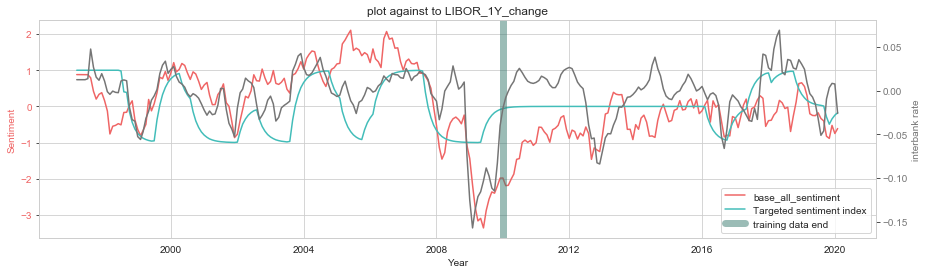

Correlation with Averaging
                 base_all_sentiment
label_2                    0.308716
LIBOR_1Y_change            0.507283
Interest_rate              0.524396
change_of_rate             0.227588
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.327217
base_all_sentiment         0.327217            1.000000


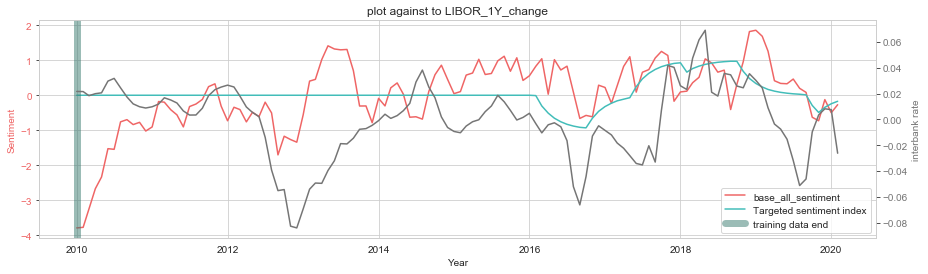

Correlation with Averaging
                 base_all_sentiment
label_2                    0.209032
LIBOR_1Y_change           -0.017523
Interest_rate              0.023492
change_of_rate             0.092432
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.327217
base_all_sentiment         0.327217            1.000000


In [274]:
def ML_method_on_word2vec(dataset_1,n,a=0.5):
    end_date = dataset.index[n]
    X_train = dataset_1[:n,:]
    X_test  = dataset_1[n:,:]
    y = ssm.winsorize(dataset.iloc[:,-1].values, limits=[0.05, 0.05])
    y_train = y[:n]
    y_test = y[n:]
    text_clf = Pipeline([
                         ('clf', Ridge(alpha=a)),
                         ])



    text_clf.fit(X_train, y_train)

    predicted_train_prob = text_clf.predict(X_train)
    predicted_test_prob = text_clf.predict(X_test)

    result = dataset.copy()
    result.iloc[:,-1] =ssm.winsorize(result.iloc[:,-1].values, limits=[0.05, 0.05])
    result.loc[:,'base_all_sentiment'] = list(predicted_train_prob)+list(predicted_test_prob)
    result_NB,result_NB2 = rolling_averaging_ewm(result.loc[:,['label_2','base_all_sentiment']])
    result_NB.loc[:,'base_all_sentiment'] = (result_NB.loc[:,'base_all_sentiment']-result_NB.loc[:,'base_all_sentiment'].mean())/np.std(result_NB.loc[:,'base_all_sentiment'])
    create_comparison_plot(result_NB,'base_all_sentiment',rate = 'LIBOR_1Y_change', end_date=end_date)
    print('Correlation with Averaging')
    print(result_NB.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment']])
    print('Correlation No Averaging')
    print(result_NB2.corr())
    result_NB,result_NB2 = rolling_averaging_ewm(result.loc[:,['label_2','base_all_sentiment']],start=end_date)
    result_NB.loc[:,'base_all_sentiment'] = (result_NB.loc[:,'base_all_sentiment']-result_NB.loc[:,'base_all_sentiment'].mean())/np.std(result_NB.loc[:,'base_all_sentiment'])
    create_comparison_plot(result_NB,'base_all_sentiment',rate = 'LIBOR_1Y_change', end_date=end_date)
    print('Correlation with Averaging')
    print(result_NB.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment']])
    print('Correlation No Averaging')
    print(result_NB2.corr())
    return None

ML_method_on_word2vec(dataset_1,500,0.5)

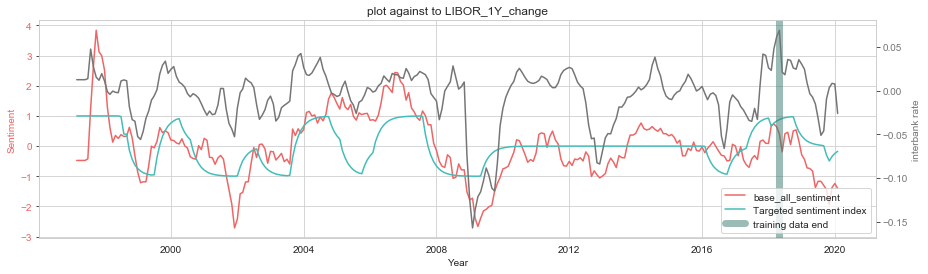

Correlation with Averaging
                 base_all_sentiment
label_2                    0.564054
LIBOR_1Y_change            0.583700
Interest_rate              0.362219
change_of_rate             0.298155
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.356459
base_all_sentiment         0.356459            1.000000


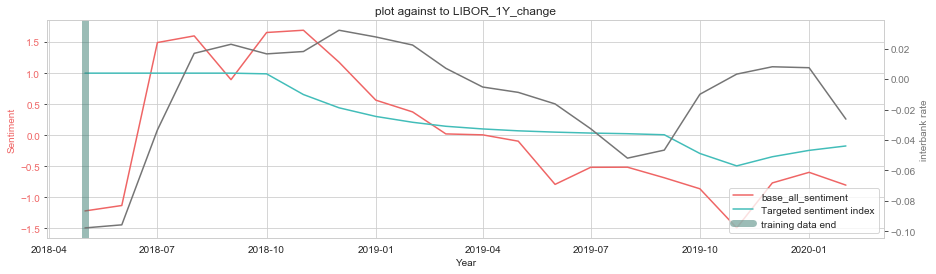

Correlation with Averaging
                 base_all_sentiment
label_2                    0.606294
LIBOR_1Y_change            0.569862
Interest_rate             -0.087435
change_of_rate             0.349132
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.356459
base_all_sentiment         0.356459            1.000000


In [275]:
ML_method_on_word2vec(dataset_2,950,0.5)

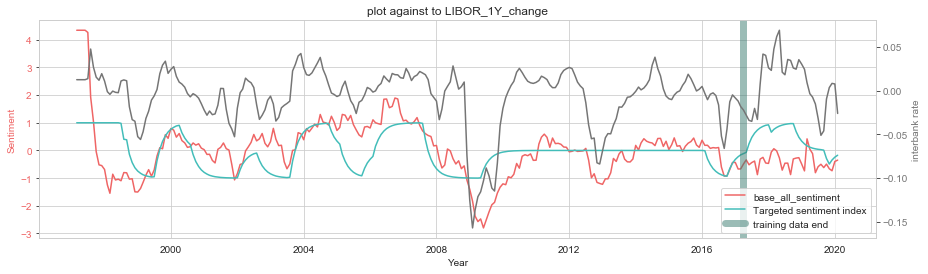

Correlation with Averaging
                 base_all_sentiment
label_2                    0.398155
LIBOR_1Y_change            0.552594
Interest_rate              0.324587
change_of_rate             0.331665
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.418167
base_all_sentiment         0.418167            1.000000


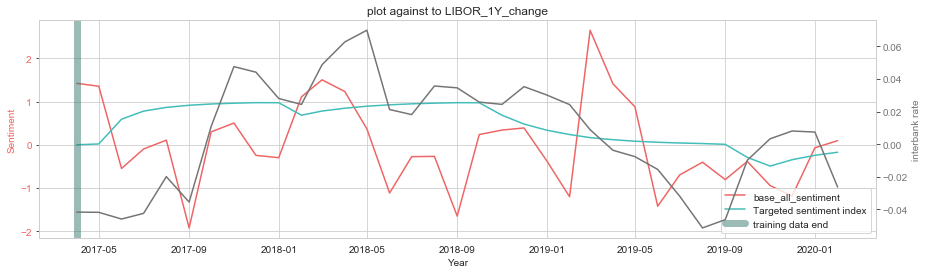

Correlation with Averaging
                 base_all_sentiment
label_2                    0.006945
LIBOR_1Y_change            0.157775
Interest_rate             -0.148984
change_of_rate             0.028811
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.418167
base_all_sentiment         0.418167            1.000000


In [233]:
ML_method_on_word2vec(dataset_3,900)

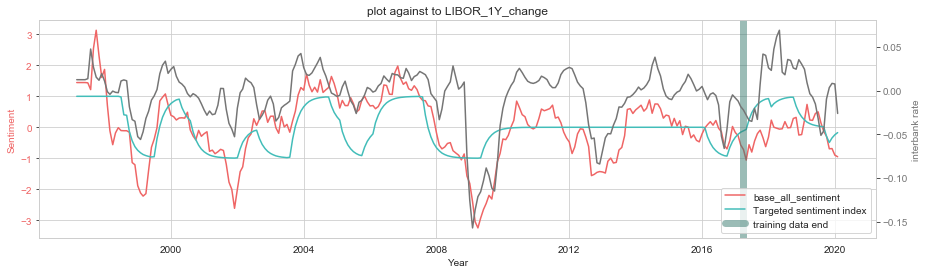

Correlation with Averaging
                 base_all_sentiment
label_2                    0.596376
LIBOR_1Y_change            0.693134
Interest_rate              0.279665
change_of_rate             0.408991
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.400951
base_all_sentiment         0.400951            1.000000


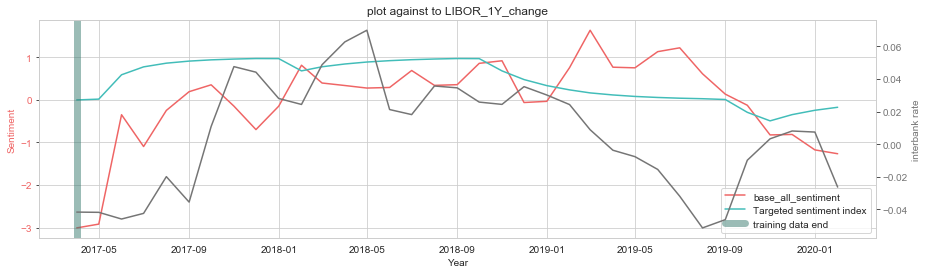

Correlation with Averaging
                 base_all_sentiment
label_2                    0.279874
LIBOR_1Y_change            0.325248
Interest_rate              0.425087
change_of_rate             0.024322
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment
LIBOR_1Y_change            1.000000            0.400951
base_all_sentiment         0.400951            1.000000


In [234]:
ML_method_on_word2vec(dataset_4,900)

# Appendix:
## A.1: topical distribution of speech & minutes and its evolvement over time

In [223]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models import TfidfModel
import multiprocessing
num_cores = multiprocessing.cpu_count() 


''' using parallel joblist'''
from joblib import Parallel, delayed
from tqdm import tqdm



# compute coherence
def calculate_coherence(corpus,dictionary,n_topics):
    lda = LdaModel(corpus, num_topics = n_topics, id2word = dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    return coh



'''
All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.
'''
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
def topic_assignment(model,corps):
    a = model.get_document_topics(corps)
    a.sort(key=lambda x:-x[1])
    return a[0][0]

In [207]:



def filter_para(paragraph_list):                                  
    paragraph_list = [i for i in paragraph_list if i != '']
    for n in range(len(paragraph_list)-1,-1,-1):
        if 'were present:' in paragraph_list[n]:
            paragraph_list = paragraph_list[:n]
    return paragraph_list

def clean_text(file):
    #file = 'Minutes of the MPC Meeting held on 12 and 13 January 2000_1st.docx'
    document = docx.Document("./scripter/converted_files/{}/{}".format(folder,file))
    Document_list = []   # each element represent one heading (section)
    paragraph_list = []  # each element represent one paragraph in each section
    start_record = False
    force_stop = False

    if sum(['Heading' in para.style.name for para in document.paragraphs])>=2:
        for para in document.paragraphs:
            if 'Heading' in para.style.name and force_stop == False:
                if 'ANNEX:' in para.text and start_record==True:   
                    force_stop = True

                elif start_record == False:
                    paragraph_list.append(para.text)
                    start_record = True

                elif start_record == True: 
                    Document_list.append(filter_para(paragraph_list))
                    paragraph_list = [para.text]

            elif para.style.name in ['List Paragraph','Body Text'] and start_record == True and force_stop == False:
                if len(para.text.split())>=4:
                    paragraph_list.append(re.sub(r'[0-9]+', '',re.sub(r'[^\x00-\x7F]+',' ',para.text.replace('\uf0be','').replace('\t','').replace("\'","'"))))

    Document_list.append(filter_para(paragraph_list))
    try:
        doc2 = []
        for i in Document_list:
            doc2.append(i)
            if 'immediate policy decision' in i[0]:
                break
        Document_list = [i for n,i in enumerate(doc2) if len(i)>=3 or n>=3]
    except:
        Document_list = [i for n,i in enumerate(Document_list) if len(i)>=3 or n>=3]
    return Document_list

def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes
def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None
    
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list

def remove_topics(x):
    x = decode_doc_minutes(x)
    result =[]
    for i in x:
        result += i[1:]
    return result

def unstructured_speech_language(string):
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    return doc_list



In [201]:
black_list = ['These are the minutes of the special Monetary Policy Committee meeting held on 8 October 2008.',
             'MINUTES OF THE SPECIAL MONETARY POLICY COMMITTEE MEETING HELD ON 18 SEPTEMBER 2001',
             'These are the Minutes of the special Monetary Policy Committee meeting held on 18 September 2001.',
             'Minutes of the special Monetary Policy Committee meeting on 19 March 2020 and the Monetary Policy Committee meeting ending on 25 March 2020']

all_minutes_cleaned = load_up_from_cleaned_minutes()
all_minutes_cleaned.loc[:,'N_topics'] = [len(decode_doc_minutes(i)) for i in all_minutes_cleaned.document_string]
all_minutes_cleaned = all_minutes_cleaned.loc[all_minutes_cleaned['N_topics']>=2,:]
all_minutes_cleaned.loc[:,'unstructured_string'] = all_minutes_cleaned.loc[:,'document_string'].apply(lambda x: remove_topics(x))
all_minutes_cleaned.head()


Unnamed: 0                                              title  \
0           0         Bank Rate maintained at 01% - May 2020_1st   
1           1       Bank Rate maintained at 01% - March 2020_1st   
2           2  Minutes of the special Monetary Policy Committ...   
3           3    Bank Rate maintained at 075% - January 2020_1st   
4           4   Bank Rate maintained at 075% - December 2019_1st   

                                                link              date  \
0  https://www.bankofengland.co.uk/monetary-polic...       07 May 2020   
1  https://www.bankofengland.co.uk/monetary-polic...     26 March 2020   
2  https://www.bankofengland.co.uk/monetary-polic...     13 March 2020   
3  https://www.bankofengland.co.uk/monetary-polic...   30 January 2020   
4  https://www.bankofengland.co.uk/monetary-polic...  19 December 2019   

                                          tag  content  \
0  // News // Monetary Policy Committee (MPC)      NaN   
1  // News // Monetary Policy Committee (MPC)      NaN   
2  // News // Monetary Policy Committee (MPC)      NaN   
3  // News // Monetary Policy Committee (MPC)      NaN   
4  // News // Monetary Policy Committee (MPC)      NaN   

                                            download  \
0  https://www.bankofengland.co.uk/-/media/boe/fi...   
1  https://www.bankofengland.co.uk/-/media/boe/fi...   
2  https://www.bankofengland.co.uk/-/media/boe/fi...   
3  https://www.bankofengland.co.uk/-/media/boe/fi...   
4  https://www.bankofengland.co.uk/-/media/boe/fi...   

                                     document_string  N_topics  \
0  Monetary Policy Summary, May 2020##NewPara##Au...         7   
1  Monetary Policy Summary, Monetary Policy Commi...         9   
2  Monetary and financial conditions##NewPara##Si...         4   
3  Monetary Policy Summary, January 2020##NewPara...         6   
4  Monetary Policy Summary, December 2019##NewPar...         6   

                                 unstructured_string  
0  [Authorities around the world are taking actio...  
1  [The Bank of England s Monetary Policy Committ...  
2  [Since the January MPC meeting, risk appetite ...  
3  [The Bank of England s Monetary Policy Committ...  
4  [The Bank of England s Monetary Policy Committ...

In [208]:
#MPC_speech = load_up_from_cleaned_speech()
MPC_speech_cleaned = MPC_speech.copy()
MPC_speech_cleaned.loc[:,'unstructured_string'] = MPC_speech_cleaned.loc[:,'document_string'].apply(lambda x: unstructured_speech_language(x))
MPC_speech_cleaned.head()

Unnamed: 0                                              title  \
0           0  Covid-19 and monetary policy - speech by Micha...   
1           1  Monetary policy and the Bank of England’s bala...   
2           2  Monetary policy during pandemics inflation bef...   
3           3  The grand unifying theory (and practice) of ma...   
4           4  Inflation and beliefs about inflation - speech...   

                                                link           date  \
0  https://www.bankofengland.co.uk/speech/2020/sp...    28 May 2020   
1  https://www.bankofengland.co.uk/speech/2020/ge...  23 April 2020   
2  https://www.bankofengland.co.uk/speech/2020/si...  16 April 2020   
3  https://www.bankofengland.co.uk/speech/2020/ma...  05 March 2020   
4  https://www.bankofengland.co.uk/speech/2020/be...  04 March 2020   

                             tag  \
0  // Speech // Michael Saunders   
1   // Speech // Gertjan Vlieghe   
2  // Speech // Silvana Tenreyro   
3       // Speech // Mark Carney   
4     // Speech // Ben Broadbent   

                                     document_string  \
0   The views expressed here are not necessarily ...   
1   I would like to thank Rodrigo Guimaraes, Lenn...   
2   The views are not necessarily those of the Ba...   
3   I would like to thank Daisy McGregor, Nicola ...   
4   I ve received helpful comments from colleague...   

                                 unstructured_string  
0  [ The views expressed here are not necessarily...  
1  [ The Covid- pandemic is, first and foremost, ...  
2  [ The views are not necessarily those of the B...  
3  [ We covet its neat equations and crave its de...  
4  [ I ve received helpful comments from colleagu...

In [218]:
df1 =  all_minutes_cleaned.loc[:,['date','unstructured_string']]
df1.loc[:,'type'] = 'minutes'
df2 =  MPC_speech_cleaned.loc[:,['date','unstructured_string']]
df2.loc[:,'type'] = 'speech'
merged_unstructured_dataset = pd.concat([df1,df2]).set_index('date')
merged_unstructured_dataset.index = pd.DatetimeIndex(merged_unstructured_dataset.index)
merged_unstructured_dataset.sort_index()
all_sentences = []
for i in merged_unstructured_dataset.unstructured_string:
    all_sentences+=i

In [225]:
BOE_corpus = preprocess_data(all_sentences)
BOE_dictionary, BOE_corpus =  prepare_corpus(BOE_corpus)
tfidf = TfidfModel(BOE_corpus)
corpus_tfidf = tfidf[BOE_corpus]


100%|██████████| 35/35 [38:16<00:00, 65.63s/it] 

100%|██████████| 35/35 [45:06<00:00, 77.34s/it]


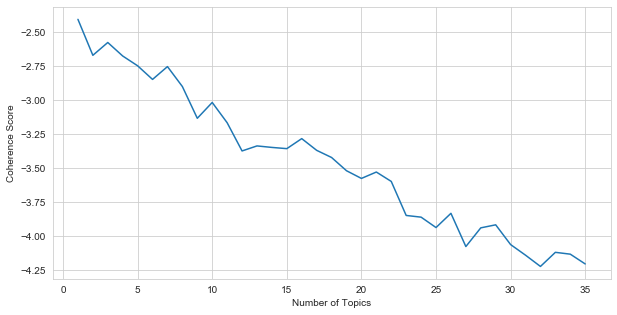

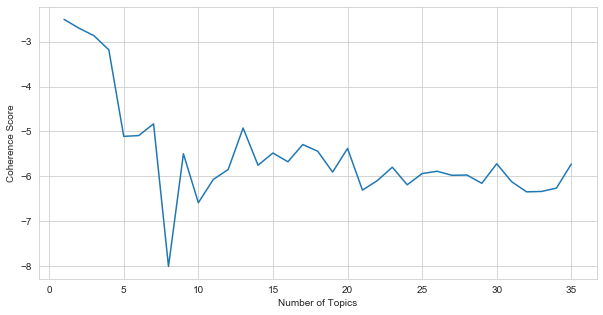

In [226]:
num_cores = multiprocessing.cpu_count() 
BOE_coherence = Parallel(n_jobs=num_cores)(delayed(calculate_coherence)(BOE_corpus,BOE_dictionary,i) for i in tqdm(range(1,36)))
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,36),BOE_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");


BOE_coherence_2 = Parallel(n_jobs=num_cores)(delayed(calculate_coherence)(corpus_tfidf,BOE_dictionary,i) for i in tqdm(range(1,36)))
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,36),BOE_coherence_2)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [ ]:
BOE_lda = LdaMulticore(corpus=BOE_corpus, num_topics = 7, id2word = BOE_dictionary, passes=10,workers=num_cores-1)

In [244]:
minutes_sentences = []
speech_sentences = []
for i in merged_unstructured_dataset.loc[merged_unstructured_dataset.loc[:,'type']=='minutes','unstructured_string']:
    minutes_sentences+=i
for i in merged_unstructured_dataset.loc[merged_unstructured_dataset.loc[:,'type']=='speech','unstructured_string']:
    speech_sentences+=i    

BOE_minutes_corpus = preprocess_data(minutes_sentences)
BOE_minutes_dictionary, BOE_minutes_corpus =  prepare_corpus(BOE_minutes_corpus)
BOE_speech_corpus = preprocess_data(speech_sentences)
BOE_speech_dictionary, BOE_speech_corpus =  prepare_corpus(BOE_speech_corpus)

In [ ]:
def visualise_lda(BOE_lda,n_words = 15):

    top_words = [[word for word,_ in BOE_lda.show_topic(topic_id, topn=n_words)] for topic_id in range(BOE_lda.num_topics)]
    top_betas = [[beta for _,beta in BOE_lda.show_topic(topic_id, topn=n_words)] for topic_id in range(BOE_lda.num_topics)]


    for i in range(7):
        plt.figure(figsize=(10,4))
        ax = plt.subplot(1,1,1)
        plt.barh(range(n_words), top_betas[i][:n_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(n_words))
        ax.set_yticklabels(top_words[i][:n_words])
        plt.title("Topic "+str(i))
        plt.show()
    return None

def count_topics(data,BOE_speech_lda):
    data = preprocess_data(data)
    _, corpus =  prepare_corpus(data)
    corpus_tfidf = TfidfModel(corpus)[corpus]
    result = np.array([0 for i in range(7)])
    for n,sentence in enumerate(corpus_tfidf):
        a = BOE_speech_lda.get_document_topics(sentence)
        a.sort(key=lambda x:-x[1])
        if a[0][1]>= 0.6:
            result[a[0][0]]+=1
    return result 

def count_topics_prob(data,BOE_speech_lda):
    data = preprocess_data(data)
    _, corpus =  prepare_corpus(data)
    corpus_tfidf = TfidfModel(corpus)[corpus]
    result = np.array([0.0 for i in range(7)])
    for n,sentence in enumerate(corpus_tfidf):
        a = BOE_speech_lda.get_document_topics(sentence)
        result+=np.array([i[1] for i in a])
    return result 


def visualize_topic_distribution(speech_dataset):
    from scipy.stats import entropy
    lda_topics = ['0','1','2','3','4','5','6']
    df = speech_dataset.copy().loc[:,'topics']
    df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
    df = df.groupby(df.index).apply(lambda x: np.sum(x)/np.sum(np.sum(x)))
    
    
    plt.figure(figsize=(10,5))
    plt.stackplot(pd.to_datetime(df.index),[i[0] for i in df],[i[1] for i in df],[i[2] for i in df],
                  [i[3] for i in df],[i[4] for i in df],[i[5] for i in df],[i[6] for i in df],
                  labels=lda_topics)
    plt.legend()
    plt.title('topic assignment')
    plt.show()
    
    df = speech_dataset.copy().loc[:,'topics']
    df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
    df = df.groupby(df.index).apply(lambda x: entropy(np.sum(x)/np.sum(np.sum(x))))
    
    plt.figure(figsize=(10,5))
    plt.plot(pd.to_datetime(df.index),df.values)
    plt.title('topic assignment entropy')
    plt.show()    
    
    
    
    
    df = speech_dataset.copy().loc[:,'topics_dis']
    df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
    df = df.groupby(df.index).apply(lambda x: np.sum(x)/np.sum(np.sum(x)))

    plt.figure(figsize=(10,5))
    plt.stackplot(pd.to_datetime(df.index),[i[0] for i in df],[i[1] for i in df],[i[2] for i in df],
                  [i[3] for i in df],[i[4] for i in df],[i[5] for i in df],[i[6] for i in df],
                  labels=lda_topics)
    plt.legend()
    plt.title('topic assignment')
    plt.show()
    
    
    df = speech_dataset.copy().loc[:,'topics_dis']
    df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
    df = df.groupby(df.index).apply(lambda x: entropy(np.sum(x)/np.sum(np.sum(x))))
    
    plt.figure(figsize=(10,5))
    plt.plot(pd.to_datetime(df.index),df.values)
    plt.title('topic assignment entropy')
    plt.show()    
    
    
    return None

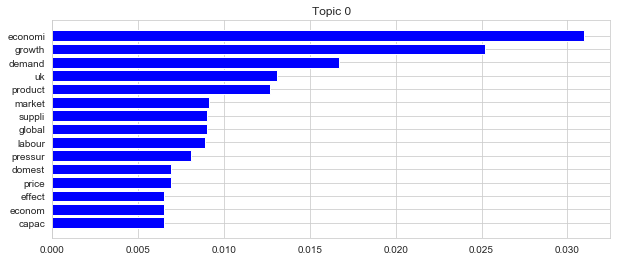

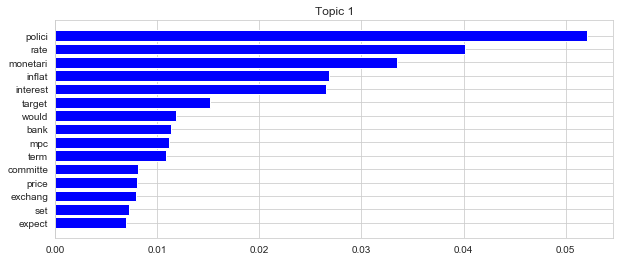

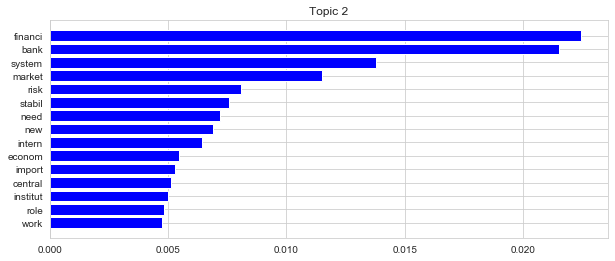

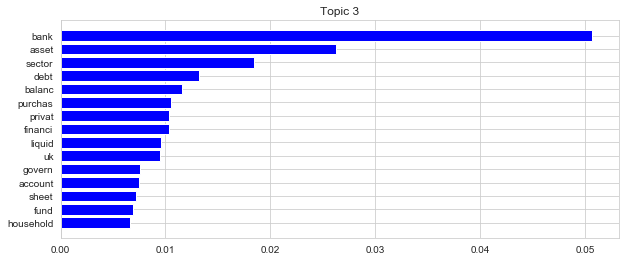

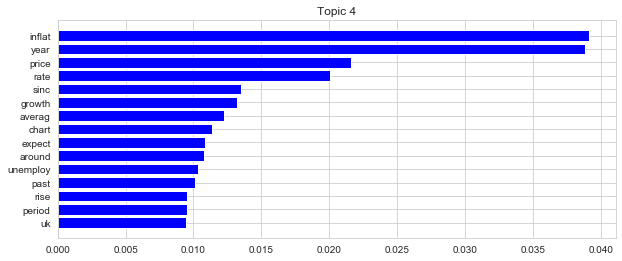

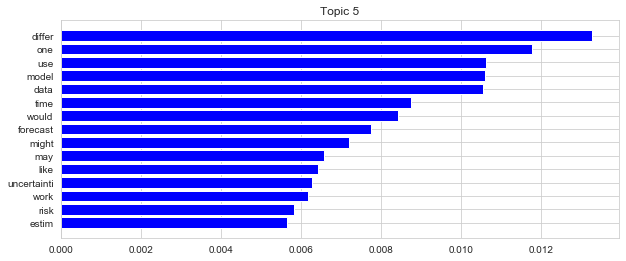

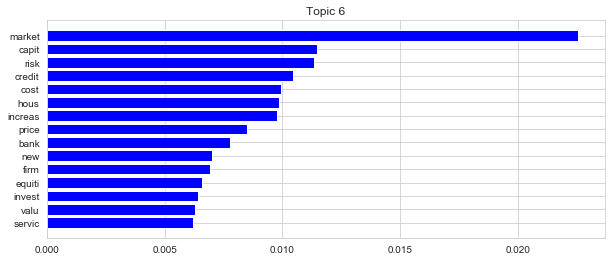

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

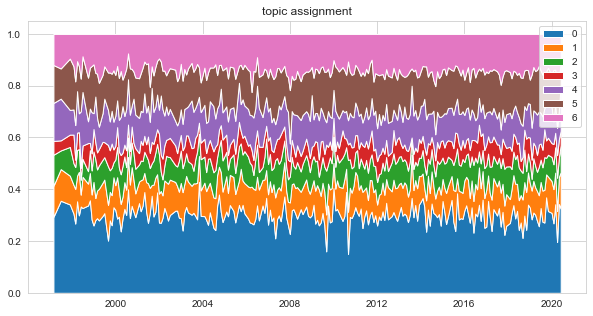

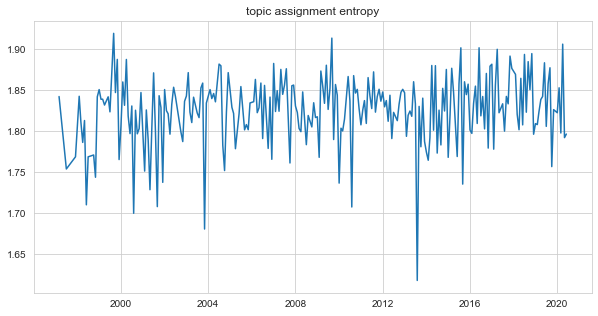

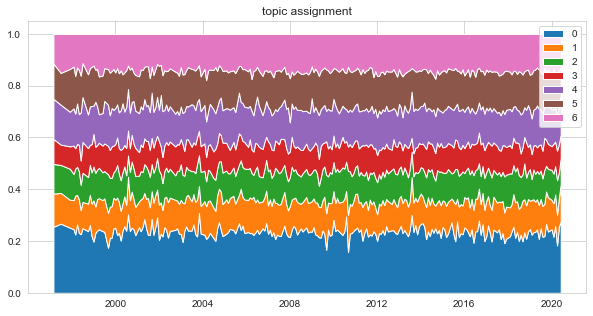

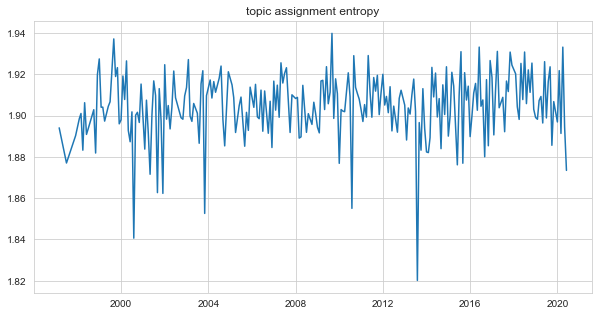

In [312]:
#BOE_speech_lda = LdaMulticore(corpus=BOE_speech_corpus, num_topics = 7, id2word = BOE_speech_dictionary, passes=10,workers=num_cores-1)
visualise_lda(BOE_speech_lda)
speech_dataset = merged_unstructured_dataset.loc[merged_unstructured_dataset.loc[:,'type']=='speech',]
speech_dataset.loc[:,'topics'] = speech_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics(x,BOE_speech_lda))
speech_dataset.loc[:,'topics_dis'] = speech_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics_prob(x,BOE_speech_lda))
visualize_topic_distribution(speech_dataset)

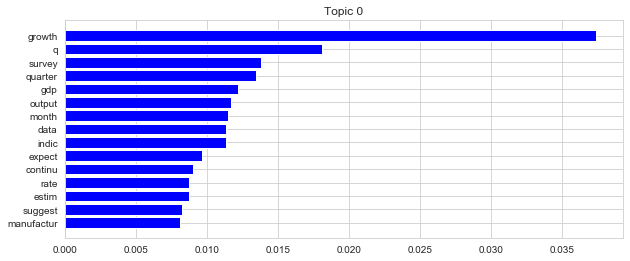

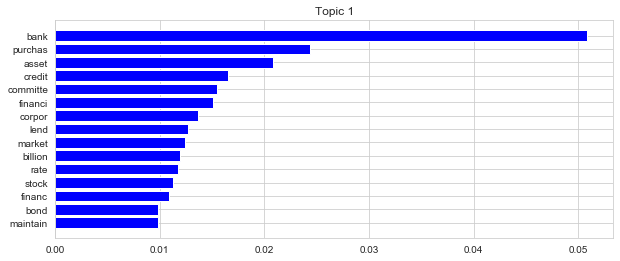

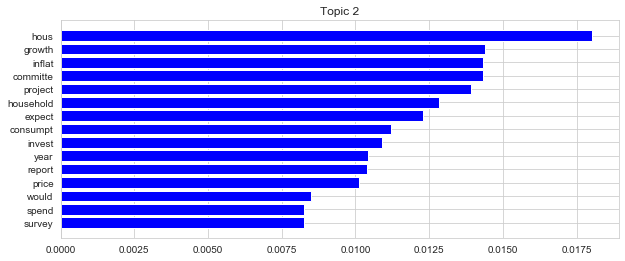

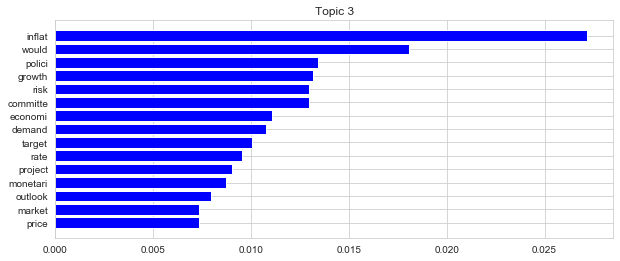

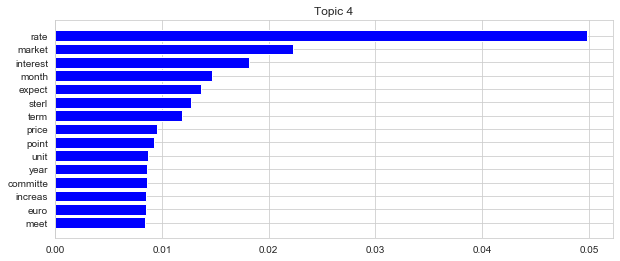

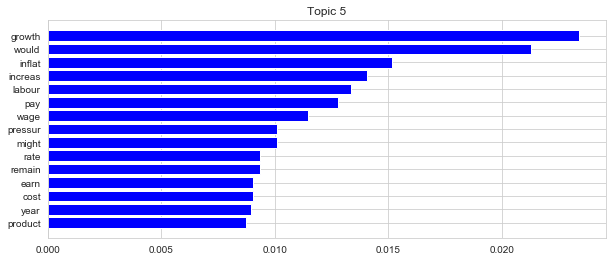

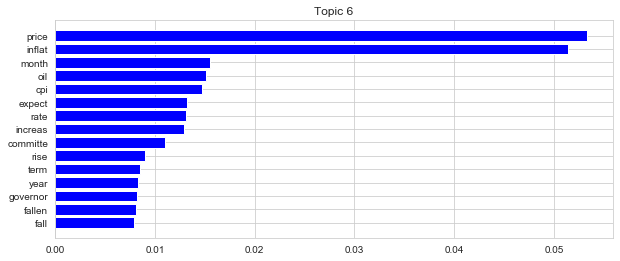

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

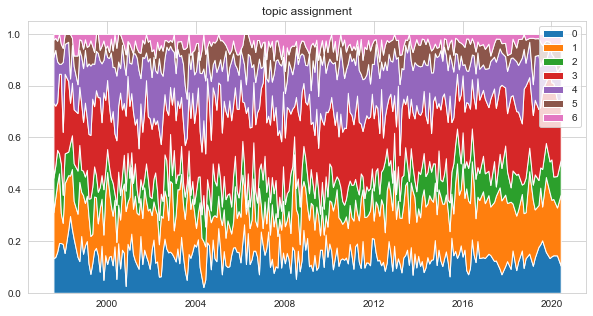

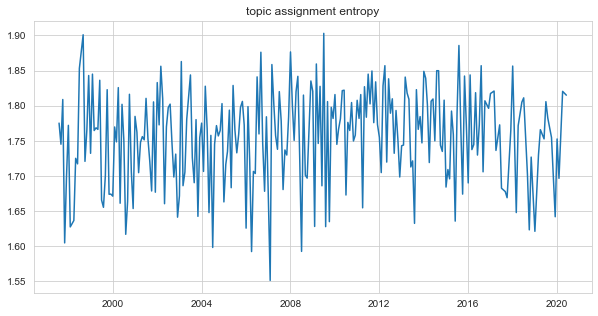

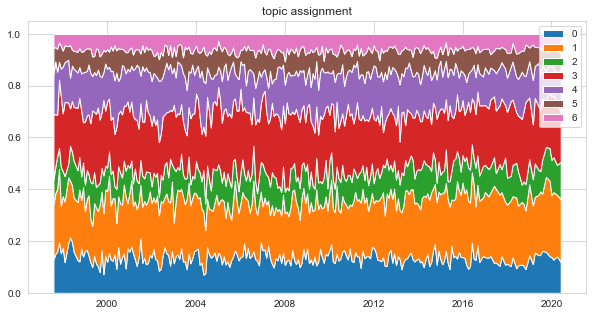

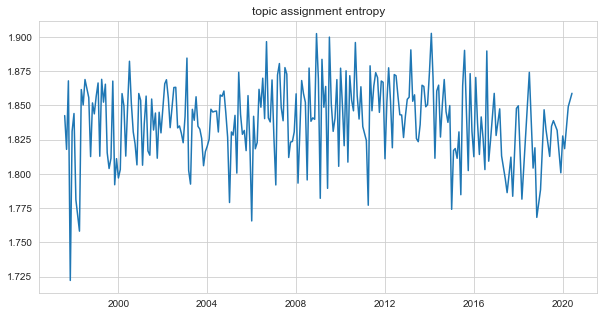

In [313]:
#BOE_minutes_lda = LdaMulticore(corpus=BOE_minutes_corpus, num_topics = 7, id2word = BOE_minutes_dictionary, passes=10,workers=num_cores-1)
visualise_lda(BOE_minutes_lda)
minute_dataset = merged_unstructured_dataset.loc[merged_unstructured_dataset.loc[:,'type']=='minutes',]
minute_dataset.loc[:,'topics'] = minute_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics(x,BOE_minutes_lda))
minute_dataset.loc[:,'topics_dis'] = minute_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics_prob(x,BOE_minutes_lda))
visualize_topic_distribution(minute_dataset)

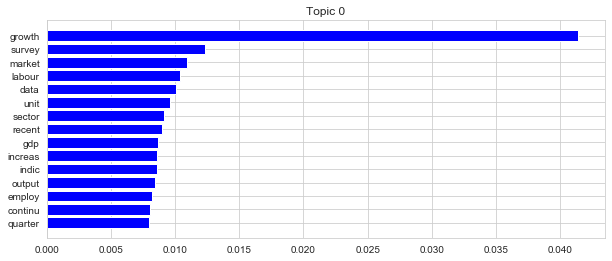

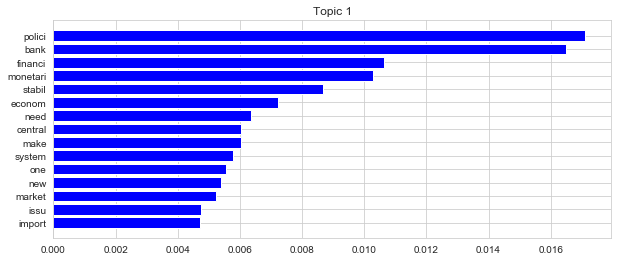

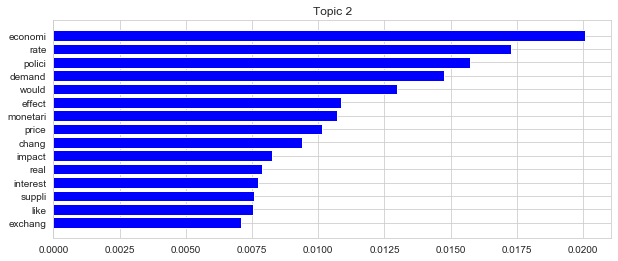

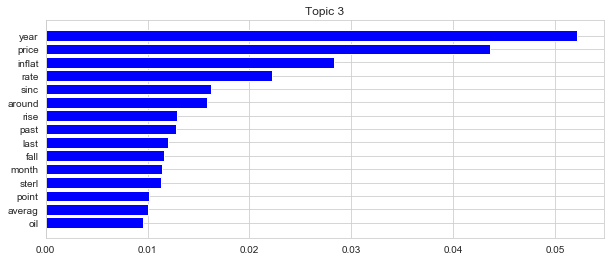

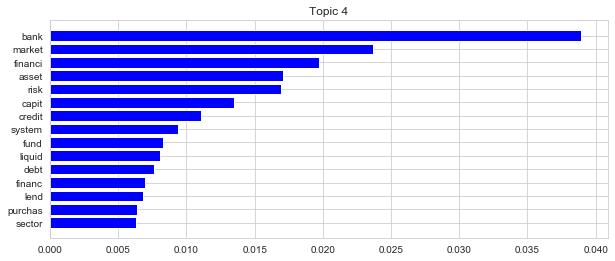

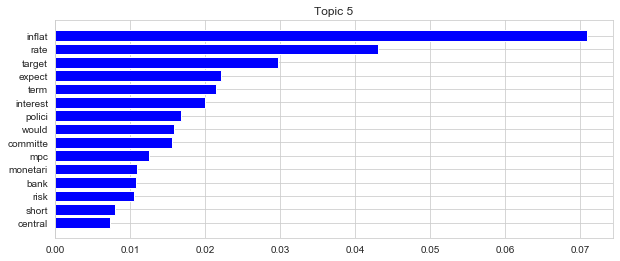

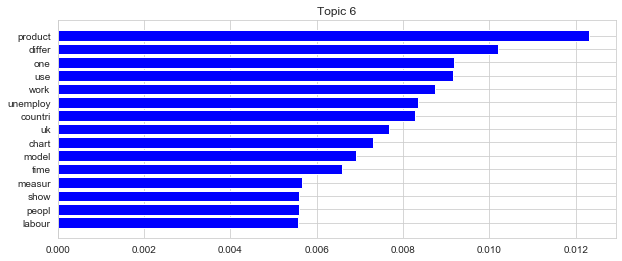

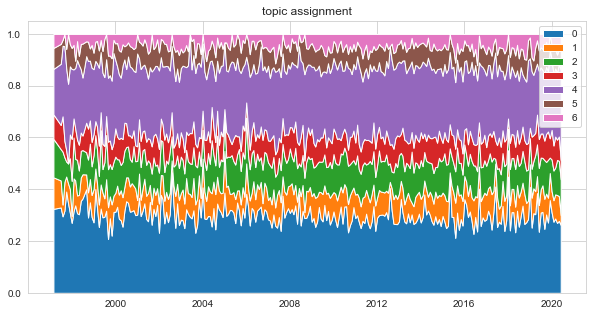

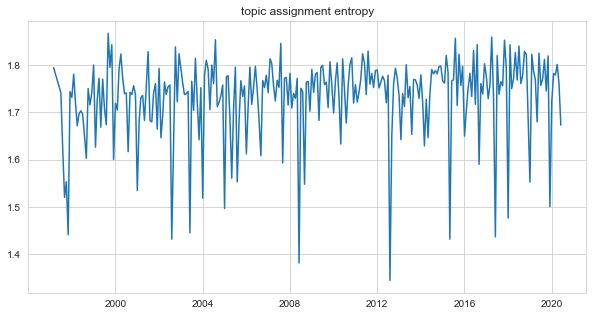

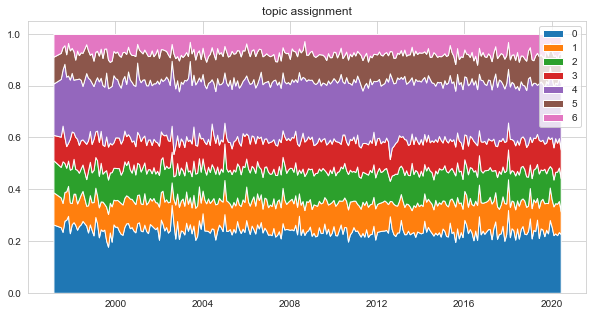

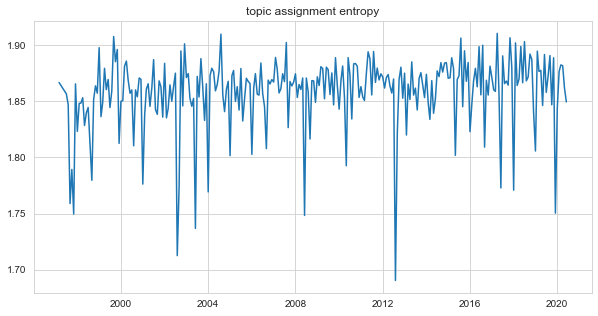

In [314]:
visualise_lda(BOE_lda)
merged_unstructured_dataset.loc[:,'topics'] = merged_unstructured_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics(x,BOE_lda))
merged_unstructured_dataset.loc[:,'topics_dis'] = merged_unstructured_dataset.loc[:,'unstructured_string'].apply(lambda x: count_topics_prob(x,BOE_lda))
visualize_topic_distribution(merged_unstructured_dataset)

In [333]:
#result,result2 = rolling_averaging_ewm(sentiment_97_15_minutes_prob)
Entropy_score  = sentiment_97_15_merged_prob.copy()
df = merged_unstructured_dataset.loc[:,'topics_dis']
df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
df = df.groupby(df.index).apply(lambda x: entropy(np.sum(x)/np.sum(np.sum(x))))
df = (df-df.mean())/np.std(df)
Entropy_score = Entropy_score.join(df,how='inner')


df = merged_unstructured_dataset.loc[:,'topics']
df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
df = df.groupby(df.index).apply(lambda x: entropy(np.sum(x)/np.sum(np.sum(x))))
df = (df-df.mean())/np.std(df)
Entropy_score = Entropy_score.join(df,how='inner')

Entropy_score,result2 = rolling_averaging_ewm(Entropy_score,addition = ['topics_dis','topics'])

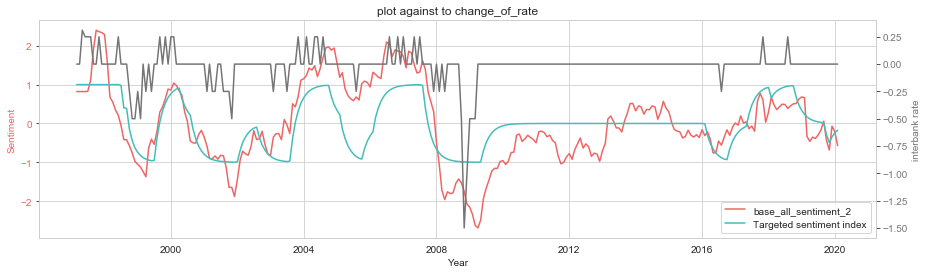

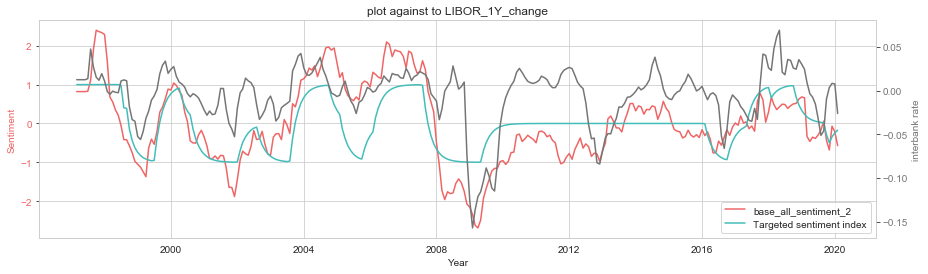

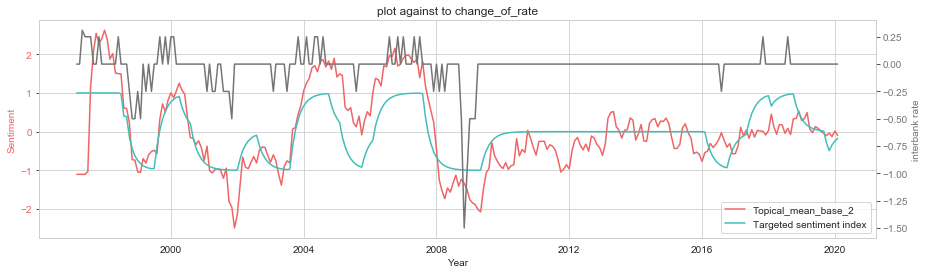

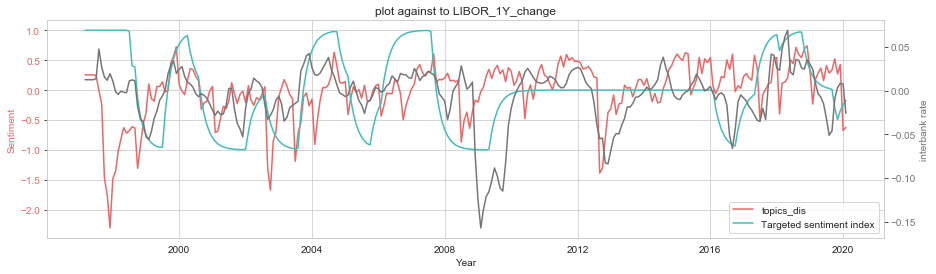

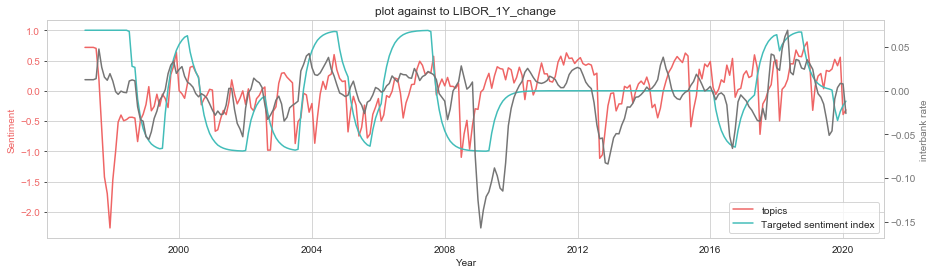

In [340]:
end_date =''
visualise_prob_model(Entropy_score)
create_comparison_plot(Entropy_score,'topics_dis',rate = 'LIBOR_1Y_change')
create_comparison_plot(Entropy_score,'topics',rate = 'LIBOR_1Y_change')

In [328]:
print('Correlation with Averaging')
print(Entropy_score.corr().loc[['label_2','LIBOR_1Y_change','Interest_rate','change_of_rate'],['base_all_sentiment_2','topics_dis','topics']])
print('Correlation No Averaging')
print(result2.corr())

Correlation with Averaging
                 base_all_sentiment  topics_dis    topics
label_2                    0.792457   -0.029294  0.001372
LIBOR_1Y_change            0.561908    0.064349  0.033931
Interest_rate              0.194781   -0.405719 -0.424219
change_of_rate             0.465796    0.087790  0.095900
Correlation No Averaging
                    LIBOR_1Y_change  base_all_sentiment  topics_dis    topics
LIBOR_1Y_change            1.000000            0.385039    0.036307  0.008060
base_all_sentiment         0.385039            1.000000   -0.035927 -0.022580
topics_dis                 0.036307           -0.035927    1.000000  0.936858
topics                     0.008060           -0.022580    0.936858  1.000000


In [ ]:
.set_index('title').join(df3,how='inner')

## A.2: Posterious distribution sentiment
Previously we have treat each positive and negative document equally and word sentiment ranking is simply the rate of coocurrence with positive.negative document. But now, we could give discrimination on different documents. In another word, here i am going to reconstruct word-frequency matrix and re-construct dictioanry.

In [404]:
def filter_speech_language_unconditional(string):
    result = {i:[] for i in topics}
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    doc_list_cleaned = preprocess_data(doc_list)
    result = []
    for i in doc_list_cleaned:
        result+=i
    result = ' '.join(result)
    return result

In [427]:
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

MPC_speech2 = load_up_from_cleaned_speech()
MPC_speech2.loc[:,'all_string'] = MPC_speech2.loc[:,'document_string'].apply(lambda x: filter_speech_language_unconditional(x))
MPC_speech2.loc[:,'N_topics'] = MPC_speech2.loc[:,'document_string'].apply(lambda x: filter_speech_language(x,topics[:-1],thre=0.65))
speech_timeseries2 = MPC_speech2.set_index('date')
speech_timeseries2.index = pd.DatetimeIndex(speech_timeseries2.index)+pd.offsets.MonthBegin(0)
speech_timeseries2 = speech_timeseries2.loc[:,['title','all_string','N_topics']]
speech_timeseries2.loc[:,'Type'] = 'Speech'
speech_timeseries2

0.397 of all sentences in speech were kept

title  \
date                                                            
2020-06-01  Covid-19 and monetary policy - speech by Micha...   
2020-05-01  Monetary policy and the Bank of England’s bala...   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-04-01  The grand unifying theory (and practice) of ma...   
2020-04-01  Inflation and beliefs about inflation - speech...   
...                                                       ...   
1998-02-01  The Chemical Industries Association Business O...   
1997-12-01  Developments in UK financial markets - speech ...   
1997-07-01  The Sixteenth Mais Lecture - speech by Edward ...   
1997-07-01      Lord Mayors Banquet - speech by Edward George   
1997-03-01  Speech by Edward George for the 3rd Euromoney ...   

                                                   all_string  \
date                                                            
2020-06-01  view express necessarili bank england monetari...   
2020-05-01  covid pandem first foremost global health issu...   
2020-05-01  view necessarili bank england monetari polici ...   
2020-04-01  covet neat equat crave determinist system inev...   
2020-04-01  receiv help comment colleagu bank england view...   
...                                                       ...   
1998-02-01  particularli plea associ confer theme sustain ...   
1997-12-01  perhap singl moment chang financi landscap uk ...   
1997-07-01  delight invit deliv sixteenth mai lectur two t...   
1997-07-01  let begin congratul chancellor overwhelm elect...   
1997-03-01  honour invit open rd euromoney intern bond con...   

                                                     N_topics    Type  
date                                                                   
2020-06-01  [[Financial markets, Moreover, with limited mo...  Speech  
2020-05-01  [[Financial markets, It is far more complex th...  Speech  
2020-05-01  [[Financial markets, Second, the policy respon...  Speech  
2020-04-01  [[Financial markets, Macroprudential policy is...  Speech  
2020-04-01  [[Financial markets, Precisely for that reason...  Speech  
...                                                       ...     ...  
1998-02-01  [[Financial markets, Many people think that - ...  Speech  
1997-12-01  [[Financial markets, The framework put in plac...  Speech  
1997-07-01  [[Financial markets, Sweeping generalisations ...  Speech  
1997-07-01  [[Financial markets, It operates with long and...  Speech  
1997-03-01  [[Financial markets, One concern at the time w...  Speech  

[783 rows x 4 columns]

In [429]:
MPC_minutes = pd.read_hdf('data.h5', 'minutes')
minutes_timeseries2 = MPC_minutes.loc[:,['date','title','N_topics']]
result = []
for doc_list in minutes_timeseries2.loc[:,'N_topics']:
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    result.append(document)
minutes_timeseries2.loc[:,'all_string'] = result    
    
minutes_timeseries2 = minutes_timeseries2.set_index('date')
minutes_timeseries2.index = pd.DatetimeIndex(minutes_timeseries2.index)+pd.offsets.MonthBegin(0)
minutes_timeseries2.loc[:,'Type'] = 'Minutes'
minutes_timeseries2.head()

merged_timeseries_all = pd.concat([speech_timeseries2,minutes_timeseries2]).sort_index(ascending=False)
label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_all.index]
merged_timeseries_all.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries_all.index]
merged_timeseries_all.loc[:,'label_2'] = label_list
merged_timeseries_all.head()

title  \
date                                                            
2020-06-01  Covid-19 and monetary policy - speech by Micha...   
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-05-01  Monetary policy and the Bank of England’s bala...   
2020-04-01  Minutes of the special Monetary Policy Committ...   

                                                   all_string  \
date                                                            
2020-06-01  view express necessarili bank england monetari...   
2020-06-01  Authorities around the world are taking action...   
2020-05-01  view necessarili bank england monetari polici ...   
2020-05-01  covid pandem first foremost global health issu...   
2020-04-01  Since the January MPC meeting, risk appetite i...   

                                                     N_topics     Type  label  \
date                                                                            
2020-06-01  [[Financial markets, Moreover, with limited mo...   Speech      0   
2020-06-01  [[Growth and inflation projections, Authoritie...  Minutes      0   
2020-05-01  [[Financial markets, Second, the policy respon...   Speech      0   
2020-05-01  [[Financial markets, It is far more complex th...   Speech      0   
2020-04-01  [[Financial markets, Since the January MPC mee...  Minutes      0   

            label_2  
date                 
2020-06-01        0  
2020-06-01        0  
2020-05-01        0  
2020-05-01        0  
2020-04-01        0

In [430]:
result = []
for doc_list in merged_timeseries_all.loc[:,'N_topics']:
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    result.append(document)
merged_timeseries_all.loc[:,'cleaned_filtered'] = result
merged_timeseries_all.loc[:,'cleaned_filtered'] = preprocess_data(list(merged_timeseries_all.loc[:,'cleaned_filtered']))
merged_timeseries_all.loc[:,'cleaned_filtered_wordlsit'] = merged_timeseries_all.loc[:,'cleaned_filtered'].apply(lambda x: ' '.join([i for i in x if i in word_list]))
merged_timeseries_all.loc[:,'cleaned_all'] = preprocess_data(list(merged_timeseries_all.loc[:,'all_string']))
merged_timeseries_all.loc[:,'cleaned_all_wordlsit'] = merged_timeseries_all.loc[:,'cleaned_all'].apply(lambda x: ' '.join([i for i in x if i in word_list]))

In [432]:
merged_timeseries_all.join(merged_dataset.loc[:,'LIBOR_1Y_change'],how='inner').to_hdf('cleaned_all.h5', key='cleaned_all', mode='w')
pd.DataFrame({'words':word_list}).to_hdf('cleaned_all.h5', key='word_list', mode='r+')

C:\Users\lunarhero\anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['title', 'all_string', 'N_topics', 'Type', 'cleaned_filtered',
       'cleaned_filtered_wordlsit', 'cleaned_all', 'cleaned_all_wordlsit'],
      dtype='object')]

  encoding=encoding,


In [38]:
def create_vector_frequency(x,word_list):
    vector = [0 for i in word_list]
    for n,word in enumerate(word_list):
        a = x.count(word)
        if a!=a:
            vector[n] = 0
        else:
            vector[n] = a
    return vector

In [39]:
dataset = pd.read_hdf('cleaned_all.h5', key='cleaned_all')
word_list = pd.read_hdf('cleaned_all.h5', key='word_list').words.values

In [40]:
filtered_dataset = dataset.loc[:,['title','Type','cleaned_filtered','cleaned_filtered_wordlsit','LIBOR_1Y_change']]
all_dataset = dataset.loc[:,['title','Type','cleaned_all','cleaned_all_wordlsit','LIBOR_1Y_change']]

In [42]:
end_date, start_date='2015-12-31','1997-08-01'

training_data = all_dataset.loc[start_date:end_date,:]
testing_data = all_dataset.loc[end_date:,:]
training_data = training_data.sort_values('LIBOR_1Y_change')
training_data = training_data.dropna()
training_data = training_data.loc[training_data.loc[:,'cleaned_all_wordlsit']!= '' ,:]
training_data.loc[:,'probability'] = [(i+1)/len(training_data) for i in range(len(training_data))]
training_data.loc[:,'length'] = training_data.loc[:,'cleaned_all_wordlsit'].apply(lambda x: len(x.split()))
training_data.loc[:,'count_vector'] = training_data.loc[:,'cleaned_all_wordlsit'].apply(lambda x: np.array(create_vector_frequency(x,word_list)))
training_data.loc[:,'count_vector'] = training_data.loc[:,'count_vector'] / training_data.loc[:,'length'] 


In [44]:
end_date, start_date='2015-12-31','1997-08-01'

training_data = filtered_dataset.loc[start_date:end_date,:]
testing_data = filtered_dataset.loc[end_date:,:]
training_data = training_data.sort_values('LIBOR_1Y_change')
training_data = training_data.dropna()
training_data = training_data.loc[training_data.loc[:,'cleaned_filtered_wordlsit']!= '' ,:]
training_data.loc[:,'probability'] = [i/len(training_data) for i in range(len(training_data))]
training_data.loc[:,'length'] = training_data.loc[:,'cleaned_filtered_wordlsit'].apply(lambda x: len(x.split()))
training_data.loc[:,'count_vector'] = training_data.loc[:,'cleaned_filtered_wordlsit'].apply(lambda x: np.array(create_vector_frequency(x,word_list)))
training_data.loc[:,'count_vector'] = training_data.loc[:,'count_vector'] / training_data.loc[:,'length'] 


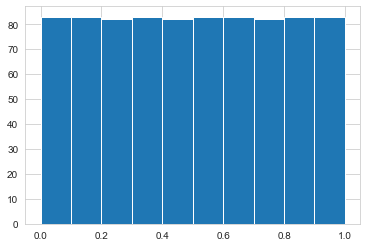

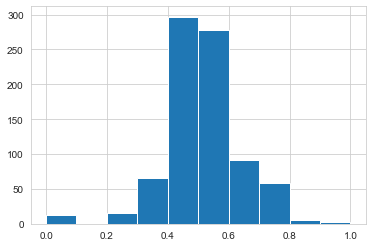

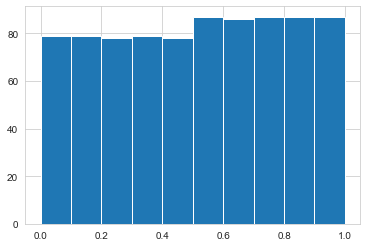

In [64]:
plt.hist(training_data.loc[:,'probability'])
plt.show()

training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'probability_2'] = (training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'LIBOR_1Y_change']-0)/(2 * max(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'LIBOR_1Y_change']))+0.5
training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'probability_2'] = (training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'LIBOR_1Y_change']-min(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'LIBOR_1Y_change']))/( 0 - 2 * min(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'LIBOR_1Y_change']))
plt.hist(training_data.loc[:,'probability_2'])
plt.show()

training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'probability_3'] = [0.5+0.5*i/len(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'LIBOR_1Y_change']) for i in range(len(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']>0,'LIBOR_1Y_change']))]
training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'probability_3'] = [0.5*i/len(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'LIBOR_1Y_change']) for i in range(len(training_data.loc[training_data.loc[:,'LIBOR_1Y_change']<=0,'LIBOR_1Y_change']))]
plt.hist(training_data.loc[:,'probability_3'])
plt.show()

In [612]:
def prediction_probability(p,d,s,lam,Matrix_O):
    return -np.nansum(d*(np.log(Matrix_O[:,0]*p+Matrix_O[:,0]*(1-p))))/s + lam*np.log(p*(1-p))
n_row = len(training_data.loc[:,'count_vector'].values[0])
n_col = len(training_data)
D_matrix = np.zeros((n_row,n_col))
Prob_vector = training_data.loc[:,'probability'].values
for n,i in enumerate(training_data.loc[:,'count_vector']):
    D_matrix[:,n]=i.reshape(1,-1)
W_matrix = np.zeros((2,n_col))
for i in range(n_col):
    W_matrix[:,i] = [Prob_vector[i],1-Prob_vector[i]]
Matrix_O = D_matrix.dot(W_matrix.T).dot(np.linalg.inv(W_matrix.dot(W_matrix.T)))

In [615]:
d_list = training_data.count_vector.values
s_list = training_data.length.values
lam = 0.5
predicted = [0 for i in d_list]
for i in range(len(predicted)):
    predicted[i] = optimize.minimize(prediction_probability,x0 = [0.7], args=(d_list[i],s_list[i],lam,Matrix_O), bounds=((0, 1),), tol=1e-10).x

C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
C:\Users\lunarhero\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [616]:
predicted


[array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.7]),
 array([0.

      fun: array([-0.03660748])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.32667268e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([0.50000001])